# MODULE 1: TIME SERIES SEGMENTATION USING GMMs

### Dataset link for the Dataset used in Module 1 
https://github.com/owid/covid-19-data/tree/master/public/data (https://ourworldindata.org/coronavirus-source-data)

We can just download the latest datasets and run the code to get the revised Predictions

https://api.covid19india.org/csv/latest/case_time_series.csv 

# Import required packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid'); sns.set_palette('dark')
import numpy as np
import pandas as pd
from pomegranate import *
from sklearn import mixture
numpy.random.seed(42)
numpy.set_printoptions(suppress=True)
from scipy.stats import rankdata
# from scipy.optimize import curve_fit
import math
import itertools
from datetime import datetime

%matplotlib inline
# %load_ext watermark
# %watermark -m -n -p numpy,scipy,pomegranate

# Data Preprocessing


Loading the Dataset from the <b>Different Countries</b>, the idea is to learn the stage transitions using 
the countries in which CORONA-VIRUS is already saturated. 

Current list of Countries to use: 
<b> 'Australia', 'Switzerland', 'China', 'India', 'Iceland','South Korea', 'New Zealand','Austria'] </b>



In [3]:
#############################################################################################
###########  Reading the Dataset and Filtering Data for Mature Countries  ###################
#############################################################################################

df =  pd.read_csv('../Data/14th July/owid-covid-data.csv', encoding = 'utf8')
countries = ['Australia', 'Switzerland', 'China', 'India', 'Iceland','South Korea', 'New Zealand','Austria'] 
df = df[df['location'].isin(countries)]

#############################################################################################
####################  Coversion to Date Time Format  ########################################
#############################################################################################

## Function Definition
def date_conversion(date_string):
    datetime_object = datetime.strptime(date_string, '%Y-%m-%d')
    return datetime_object.date()

## Applying the function
Dates= df.apply(lambda row: date_conversion(row.date), axis = 1)
df.insert(3,'Dates',Dates)
df.drop('date',axis =1,inplace=True)
df_new = df[df['total_cases']>0].copy()

#############################################################################################
#################  Adding a column storing cumulative number of days ########################
#############################################################################################

country_list = list(df['location'].unique()) 

## Function for identifying the first date
def get_first_day(country_list,df):
    f_day = [df.loc[df[df['location']==i].index[0]].Dates for i in country_list]
    return f_day

first_occurence = get_first_day(country_list, df_new)
print(first_occurence)

## Function to count number of cummulative days
def cumulative_day(country, Dates, first_occurence,country_list):
    val = (Dates - first_occurence[country_list.index(country)]).days + 1
    return val

cum_day = df_new.apply(lambda row: cumulative_day(row.location,row.Dates,first_occurence, country_list), axis = 1)
df_new.insert(3, 'cum_day',cum_day)

#############################################################################################
#################### Removing the Outlier Data Point  #######################################
#############################################################################################

## Removing the Abonormal Data point for China
df_new.drop(df_new[(df_new['location']=='China') & (df_new['new_cases']==15141)].index, axis = 0, inplace=True)
df_new.head()

#############################################################################################
###################  Removing the Dataset After a Particular Date ###########################
#############################################################################################
start_date = pd.to_datetime('2020-05-31', format='%Y-%m-%d')
whole_data = df_new
training_data = df_new[df_new['Dates']<= start_date]

del df_new
del df

[datetime.date(2020, 1, 25), datetime.date(2020, 2, 26), datetime.date(2019, 12, 31), datetime.date(2020, 2, 29), datetime.date(2020, 1, 30), datetime.date(2020, 2, 28), datetime.date(2020, 1, 20), datetime.date(2020, 2, 26)]


In [4]:
#############################################################################################
######################    Data Visualization Function    ####################################
#############################################################################################

## Generates the bar plot of number of cases
def barplot(country):
    
    plt.figure(figsize=(16,8))
    ax= sns.barplot(x= "cum_day", y = "new_cases", data = df_new[df_new['location']==country],palette='binary_r')
    ax.set(xlabel='Days', ylabel='Number of incoming cases')
    plt.title('Barplot of '+ country)

    ##plt.savefig('D:\Studies\Corona Research\Plots\Trends\ ' +country+' barplot.png',dpi = 500)
    plt.show()
    
## Generates the distplot of the number of cases
def distplot(country):
    plt.figure(figsize=(16,8))
    ax = sns.distplot(df_new[df_new['location']==country].new_cases,color='k')
    ax.set(xlabel = 'New Cases', ylabel = 'Proportion')
    plt.title('Distplot of '+ country)

    ## plt.savefig('D:\Studies\Corona Research\Plots\Trends\ ' +country+' distplot.png',dpi = 500)
    plt.show()
    

# Model Selection

1429      1.0
1430      3.0
1431      0.0
1432      0.0
1433      0.0
         ... 
26446    15.0
26447     0.0
26448    35.0
26449    32.0
26450    17.0
Name: new_cases, Length: 905, dtype: float64


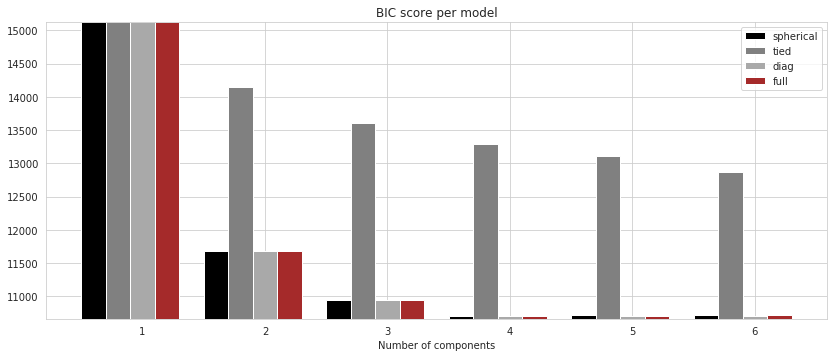

In [5]:
## Vary the number of components and the covariance type to get the best fit
cases_counts = training_data.new_cases
print(cases_counts)
day = training_data.cum_day
X = np.reshape(np.array(cases_counts),(-1,1))
#print(X)

np.random.seed(0)
lowest_bic = np.infty

bic = []
n_components_range = range(1, 7)

## Covariance Type
cv_types = ['spherical', 'tied', 'diag', 'full']


#############################################################################################
####################  Model Fitting with Different Parameters  ##############################
#############################################################################################

## Fitting the best model using a grid search cv on Covariance Type & 
## Number of Components on the basis of Bayesian Information Criterion 
for cv_type in cv_types:
    
    for n_components in n_components_range:
        
        ## Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['black', 'grey', 'darkgrey','brown'])
clf = best_gmm
bars = []

#############################################################################################
######################    Visualization of the BIC Score     ################################
#############################################################################################

## Plot the BIC scores
plt.figure(figsize=(14,12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i + 1) * len(n_components_range)],width=.2, color=color))

    
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))

spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
plt.show()

In [6]:
## To plot the result of the code. Gives the counts of daily incoming cases color coded with the stage they belong to. 
def plot_results(country):
    plt.figure(figsize=(16,4))
    plt.scatter(training_data[training_data['location']==country].cum_day,training_data[training_data['location']==country].new_cases,c=training_data[training_data['location']==country].Stages)
    
    ## To undestand the number of components which can be used
    plt.title('Day-wise Counts and Stages for '+country) 
    plt.xlabel('Day')
    plt.ylabel('Counts')
    cbar = plt.colorbar()
    cbar.set_label('Stages')
    ## plt.savefig('D:\Studies\Corona Research\Plots\Daywise Counts\ ' +country+' counts and stages.png',dpi = 500)
    plt.show()
    
## Generates the Cluster vs Stages if called
def clustervsstages(country):
    plt.figure(figsize=(16,4))
    plt.scatter(training_data[training_data['location']==country].cum_day,training_data[training_data['location']==country].Stages,
            c=training_data[training_data['location']==country].Stages)
    plt.title('Day-wise stages for '+country) #to undestand the number of components which can be used
    plt.xlabel('Day')
    plt.ylabel('Stages')
    cbar = plt.colorbar()
    cbar.set_label('Stages')
    ## plt.savefig('D:\Studies\Corona Research\Plots\Daywise Stages\ ' +country+' daywise stages.png',dpi = 500)
    plt.show()

# Determining the outbreak

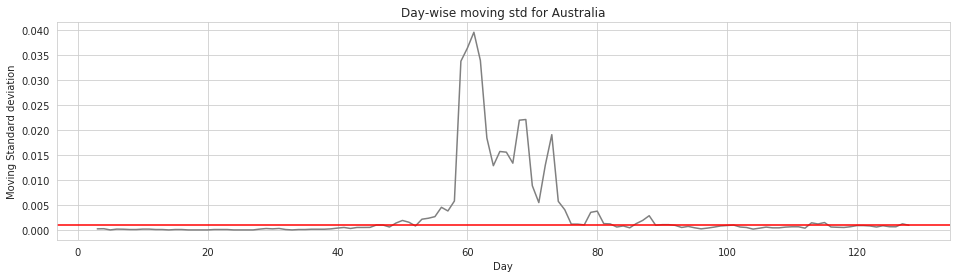

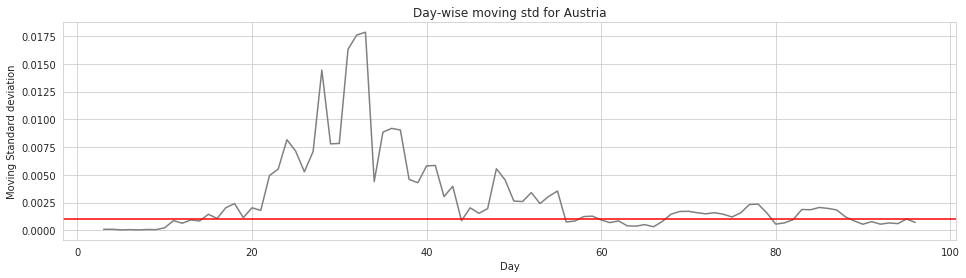

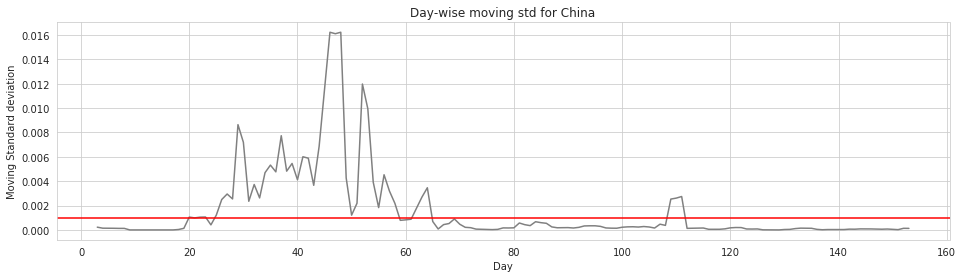

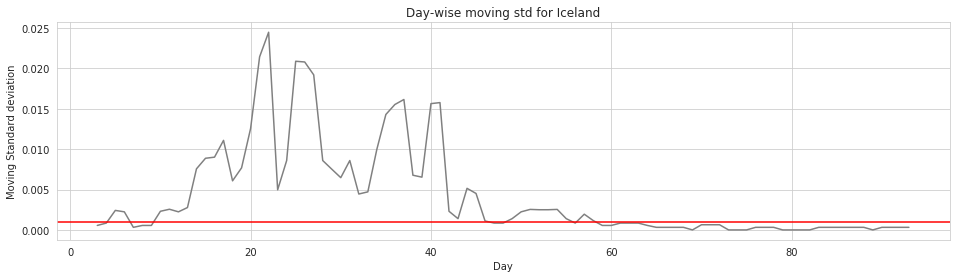

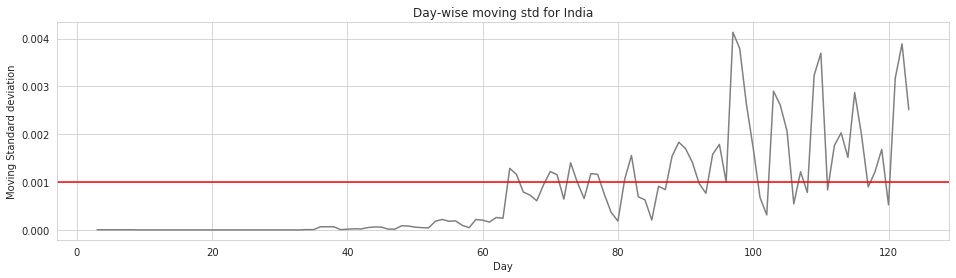

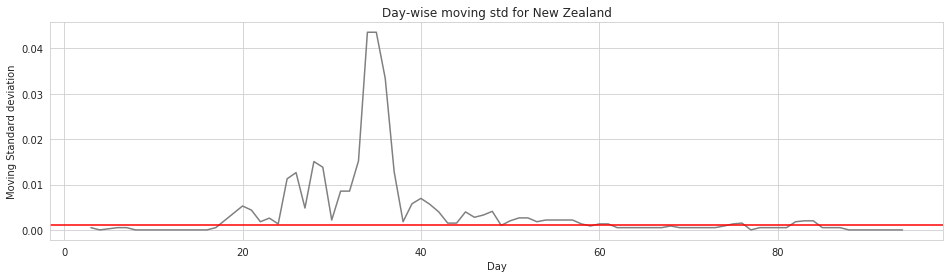

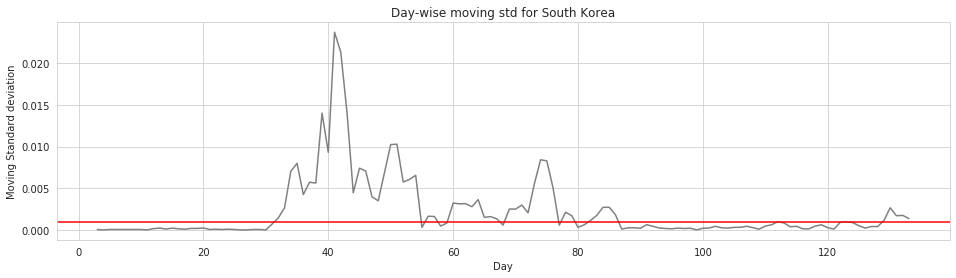

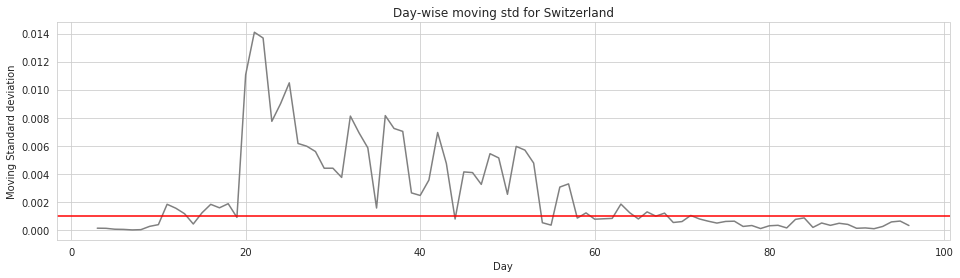

In [7]:
df_std = training_data.copy()
rol = []

## To Scale the Data
for item in country_list:
    normalised_std = df_std[df_std['location']==item].new_cases/(df_std[df_std['location']==item].new_cases.sum())
    
    ## Used to get moving standard deviation
    rol.extend(normalised_std.rolling(3).std())

## Add a column as rolling std
df_std['rolling_std']=rol
df_std.drop(df_std[df_std.rolling_std.isna()==True].index,inplace=True)

## Generates country wise plot to visualise the threshold for determining the outbreak
for item in country_list:
    plt.figure(figsize=(16,4))
    plt.plot(df_std[df_std['location']==item].cum_day,df_std[df_std['location']==item].rolling_std,color='grey')
    plt.title('Day-wise moving std for '+item) #to undestand the number of components which can be used
    plt.xlabel('Day')
    plt.ylabel('Moving Standard deviation')
    plt.axhline(y=0.001,color='r')
    ## cbar = plt.colorbar()
    ## cbar.set_label('Stages')
    plt.savefig(item+' moving std.png',dpi = 500)
    plt.show()

In [8]:
## Filtering the data based on the threshold for the outbreak
df_training = df_std[~df_std['location'].isin(['India'])]
df_training = df_std[df_std['rolling_std']>=0.001]

## Determines the cumulative day since outbreak
df_training.drop(['cum_day'],axis =1,inplace=True)
days_since_outbreak = df_training.apply(lambda row: cumulative_day(row.location,row.Dates,get_first_day(country_list, df_training), country_list), axis = 1)
df_training.insert(3, 'days_outbreak',days_since_outbreak)

/home/prerit/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
#######################################################################################
#######################################################################################
#################  GMM + PMM to Segment the Time Series ###############################
#######################################################################################
#######################################################################################

######################################################################################
#########################  Model Training Function ###################################
######################################################################################
def groupby_generator(n_mixtures,df):
    data_list = []

    input_data = np.reshape(np.array(df.new_cases),(-1,1))
    input_data_gmm = pd.concat([df.days_outbreak, df.new_cases], axis =1)
    gmm = mixture.GaussianMixture(n_components=n_mixtures,covariance_type='full')
    gmm.fit(input_data_gmm)
    means=gmm.means_
    
    d1 = PoissonDistribution(means[0][1])
    d2 = PoissonDistribution(means[1][1])
    d3 = PoissonDistribution(means[2][1])
    d4 = PoissonDistribution(means[3][1])
    model = GeneralMixtureModel([d1,d2,d3,d4])
    model.fit(input_data)
    return model


######################################################################################
#########################  Generating Predictions Function ###########################
######################################################################################
def output_generator(n_mixtures,model,input_data):
    
    ## Sequence of the Model 
    sequence = model.predict(input_data)
    unique_elements, counts_elements = np.unique(sequence, return_counts=True)
    print(unique_elements)
    ## model.clear_summaries()
    
    para = []
    for i in range(n_mixtures):
        para.append(model.distributions[i].parameters)

    #for getting the stages based on the components                 
    rank = rankdata(para, method='ordinal')
    stages = []
    for _ in range(len(sequence)):
        if sequence[_]==0:
            stages.append(rank[0])
            continue
        elif sequence[_]==1:
            stages.append(rank[1])
            continue
        elif sequence[_]==2:
            stages.append(rank[2])
            continue
        else:
            stages.append(rank[3])
        
    data_list = [(para),list(zip(unique_elements,counts_elements)),stages, sequence]
    ## dicti[country_list[j]] =data_list
    return data_list


In [10]:
df_training.head()

,iso_code,continent,location,days_outbreak,Dates,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,...,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,rolling_std
1477,AUS,Oceania,Australia,1,2020-03-13,156.0,30.0,3.0,0.0,6.118,...,44648.71,0.5,107.791,5.07,13.0,16.5,NaN,3.84,83.44,0.001373
1478,AUS,Oceania,Australia,2,2020-03-14,197.0,41.0,3.0,0.0,7.726,...,44648.71,0.5,107.791,5.07,13.0,16.5,NaN,3.84,83.44,0.001890
1479,AUS,Oceania,Australia,3,2020-03-15,249.0,52.0,3.0,0.0,9.765,...,44648.71,0.5,107.791,5.07,13.0,16.5,NaN,3.84,83.44,0.001531
1481,AUS,Oceania,Australia,5,2020-03-17,375.0,77.0,5.0,0.0,14.706,...,44648.71,0.5,107.791,5.07,13.0,16.5,NaN,3.84,83.44,0.002140
1482,AUS,Oceania,Australia,6,2020-03-18,454.0,79.0,5.0,0.0,17.804,...,44648.71,0.5,107.791,5.07,13.0,16.5,NaN,3.84,83.44,0.002334


In [11]:
######################################################################################
#########################  Preparation of Training Data  #############################
######################################################################################
df_training = df_training[~df_training['location'].isin(['India'])].groupby(['days_outbreak']).sum()
df_training.reset_index(inplace=True)

######################################################################################
#########################  Model Training  ###########################################
######################################################################################
trained_model = groupby_generator(4,df_training)
prediction_data_group =  np.reshape(np.array(df_training.new_cases),(-1,1))
output_data_group = output_generator(4,trained_model,prediction_data_group)
df_training['Stages_g']=output_data_group[2]


[0 1 2 3]


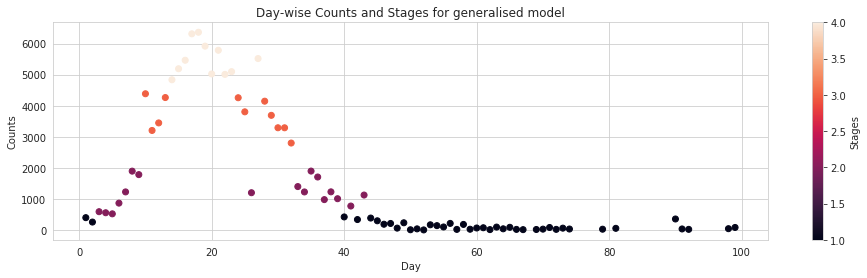

In [12]:
#To plot the result of the code. Gives the counts of daily incoming new_cases color coded with the stage they belong to.
plt.figure(figsize=(16,4))
plt.scatter(df_training[:-3].days_outbreak,df_training[:-3].new_cases,c=df_training[:-3].Stages_g,)
plt.title('Day-wise Counts and Stages for generalised model') #to undestand the number of components which can be used
plt.xlabel('Day')
plt.ylabel('Counts')
cbar = plt.colorbar()
cbar.set_label('Stages')
plt.savefig('D:\Studies\Corona Research\Plots\Daywise Counts\ '+'generalised'+' counts and stages.png',dpi = 500)
plt.show()


# MODULE 2: MARKOV MODULE 

In [13]:
def transition_matrix(arr, n=1):
    """"
    Computes the transition matrix from Markov chain sequence of order `n`.

    :arr: Discrete Markov chain state sequence in discrete time with states in 0, ..., N
    :param n: Transition order
    """

    M = np.zeros(shape=(max(arr) , max(arr) ))
    for (i, j) in zip(arr, arr[1:]):
        M[i-1, j-1] += 1

    T = (M.T / M.sum(axis=1)).T

    return np.linalg.matrix_power(T, n)

In [14]:
tpm_group = transition_matrix(df_training.Stages_g)

In [155]:
pd.DataFrame(tpm_group)

,0,1,2,3
0,0.930233,0.069767,0.000000,0.000000
1,0.176471,0.705882,0.058824,0.058824
2,0.000000,0.181818,0.727273,0.090909
3,0.000000,0.000000,0.181818,0.818182


In [16]:
np.linalg.matrix_power(tpm_group,30)

array([[0.55271504, 0.20534021, 0.12097237, 0.12097237],
       [0.51938995, 0.20766666, 0.13647169, 0.13647169],
       [0.4879026 , 0.20986777, 0.15111546, 0.15111417],
       [0.4578814 , 0.21195381, 0.16508175, 0.16508304]])

In [17]:
np.linalg.matrix_power(tpm_group,50)

array([[0.52949806, 0.20696061, 0.13177066, 0.13177066],
       [0.52348861, 0.20738   , 0.1345657 , 0.1345657 ],
       [0.51781092, 0.20777623, 0.13720643, 0.13720643],
       [0.51239609, 0.20815411, 0.1397249 , 0.1397249 ]])

In [18]:
#Given a TPM and initial state, helps to get the first passage time
def first_passage_time(tpm,init_state):
    step_1 = np.delete(tpm,init_state-1,1)
    step_2 = np.delete(step_1,init_state-1,0)
    a = step_2-np.identity(step_1.shape[1])
    b = -1*np.ones(step_2.shape[0])
    val = np.linalg.solve(a,b)
    return val
    
    

In [154]:
f1 = first_passage_time(tpm_group,1)
f2 = first_passage_time(tpm_group,2)
f3 = first_passage_time(tpm_group,3)
f4 = first_passage_time(tpm_group,4)
concatenated = np.array([f1,f2,f3,f4])
fpt = np.zeros((4,4))
for i in range(4):
    k =0 
    for j in range(4):
        if (i!=j):
            fpt[i,j]=concatenated[i,k]
            k+=1
pd.DataFrame(fpt)

,0,1,2,3
0,0.000000,13.00,21.25,26.75
1,14.333333,0.00,8.25,13.75
2,47.083333,32.75,0.00,5.50
3,62.083333,47.75,35.50,0.00


In [20]:
def getStages(fpt,second_last,last,predict_range): ## assumes index 1-4 in input
    fpt1 = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            if i>j:
                fpt1[i,j]=fpt[i,j]-fpt[i,j+1]
            elif (i<j):
#                 print(i,j)
                fpt1[i,j]=fpt[i,j]-fpt[i,j-1]
#     print(fpt1)
    seq = []
    if(second_last<last):
        if(last!=4):
            temp_arr = fpt1[last-1]
            for x in range(last-1,4):
                for i in range(1,int(temp_arr[x]-1)):
                    seq.append(x)
                seq.append(x+1)
            last+=1
        temp_arr = fpt1[3]
        for x in range(4,1,-1):
            for i in range(1,int(temp_arr[x-2]-1)):
                seq.append(x)
            seq.append(x-1)
    else:
        temp_arr = fpt1[last-1]
        for x in range(last,1,-1):
            for i in range(1,int(temp_arr[x-2]-1)):
                seq.append(x)
            seq.append(x-1)
#     print(seq)
    if len(seq)<predict_range:
        for j in range(predict_range-len(seq)):
            seq.append(1)
    else:
        seq = seq[:predict_range]
    return list(seq)

In [21]:
df_seq = df_std[df_std['rolling_std']>=0.000]

In [22]:
#Generating data with stages as output. These stages are used by module 3 for further forecasting.
stage = []
for item in country_list:
    val = df_seq[df_seq['location']==item].new_cases
    pred =  np.reshape(np.array(val),(-1,1))
    output = output_generator(4,trained_model,pred)
    stage.extend(output[2])
df_seq['Stages'] = stage
print(len(stage))
print(stage)

[1 3]
[1 3]
[1 2 3]
[1]
[0 1 2 3]
[1]
[1 3]
[1 3]
889
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [23]:
df_seq = df_seq[df_seq['location'].isin(['India'])]
whole_data = whole_data[whole_data['location'].isin(['India'])]

In [24]:
df_seq = df_seq.drop(['tests_units','population','population_density','median_age', 'aged_65_older','aged_70_older','gdp_per_capita','extreme_poverty','diabetes_prevalence','female_smokers','male_smokers','hospital_beds_per_thousand','rolling_std','cvd_death_rate','handwashing_facilities','iso_code'], axis = 1)
whole_data = whole_data.drop(['tests_units','population','population_density','median_age', 'aged_65_older','aged_70_older','gdp_per_capita','extreme_poverty','diabetes_prevalence','female_smokers','male_smokers','hospital_beds_per_thousand','life_expectancy','cvd_death_rate','handwashing_facilities','iso_code'], axis = 1)

In [153]:
Stages = df_seq[['Dates', 'Stages']]
Stages.to_csv('Stages_30th_May.csv')

In [25]:
df_seq = df_seq.reset_index().drop('index', axis = 1)

In [27]:
df_seq.to_csv('Covid_cases_and_stages_May_31.csv')

### Dataset link for the Dataset used in Module 3.1  
We can just download the latest datasets and run the code to get the revised Predictions

https://api.covid19india.org/csv/latest/case_time_series.csv 

# MODULE 3.1:  SIR Model For Baseline Predictions

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid'); sns.set_palette('dark')
import numpy as np
import pandas as pd
from pomegranate import *
from sklearn import mixture
from sklearn.linear_model import Ridge
numpy.random.seed(42)
numpy.set_printoptions(suppress=True)
from scipy.stats import rankdata
# from scipy.optimize import curve_fit
import math
import itertools
from datetime import datetime
from datetime import timedelta
from sklearn.metrics import mean_squared_error
# %load_ext watermark
# %watermark -m -n -p numpy,scipy,pomegranate



In [29]:
#Loading the dataset
df =  pd.read_csv('../Data/14th July/case_time_series.csv', encoding = 'utf8')

def date_conversion(date_string):
    datetime_object = datetime.strptime(date_string+' '+str(2020), '%d %B %Y')
    return datetime_object.date()

df['Date']= df.apply(lambda row: date_conversion(row.Date), axis = 1)

df = df[df['Date']<=start_date]

## Backward Generator Data Preparation
df_n = df[df['Total Confirmed']>=6]
bkwd_pred_range = len(df_n)-2

In [30]:
dates = list(df_n.Date)
date1 = dates[0]
date2 = dates[-1]
# date3 = dates[-8]
print(date1, date2)

2020-03-03 2020-05-31


In [31]:
def get_first_day(df):
    return df.loc[0].Date
first_occurence = get_first_day(df)

## Cumulative Date Column Addition
def cumulative_day(Dates,first_occurence):
    val = (Dates-first_occurence).days + 1
    return val

# cum_day('China',first_occurence[0],first_occurence, country_list)
df['cum_day'] = df.apply(lambda row: cumulative_day(row.Date,first_occurence), axis = 1)
# df_new.insert(3, 'cum_day',cum_day)

threshold = 6
df['infected_t'] = df['Total Confirmed'] - df['Total Recovered'] - df['Total Deceased']
df_beta = df[df['Total Confirmed']<threshold]
df = df[df['Total Confirmed']>=threshold]


In [32]:
def cal_parameters(data):
    data['beta_t']=(-data['infected_t'].diff(periods=-1)  - data['Total Recovered'].diff(periods=-1)-
                    data['Total Deceased'].diff(periods=-1))/((data['infected_t']))
    data[data['beta_t']<0]['beta_t']=0
    data['gamma_t'] = (- data['Total Recovered'].diff(periods=-1))/((data['infected_t']))
    data[data['gamma_t']<0]['gamma_t']=0.0769
    data['mu_t'] = (- data['Total Deceased'].diff(periods=-1))/((data['infected_t']))
    data[data['mu_t']<0]['mu_t']=0
    return data


In [33]:
df = cal_parameters(df)
df_beta = cal_parameters(df_beta)

In [34]:
df_beta.tail()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased,cum_day,infected_t,beta_t,gamma_t,mu_t
28,2020-02-27,0,3,0,3,0,0,29,0,NaN,NaN,NaN
29,2020-02-28,0,3,0,3,0,0,30,0,NaN,NaN,NaN
30,2020-02-29,0,3,0,3,0,0,31,0,NaN,NaN,NaN
31,2020-03-01,0,3,0,3,0,0,32,0,inf,NaN,NaN
32,2020-03-02,2,5,0,3,0,0,33,2,NaN,NaN,NaN


In [35]:
med_gamma= df.gamma_t.median()
med_beta = df.beta_t.median()
med_mu = df.mu_t.median()

In [36]:
df['beta_t'].replace([np.inf,-np.inf,np.nan],med_beta,inplace=True)
df['gamma_t'].replace([np.inf,-np.inf,np.nan],med_gamma,inplace=True)
df['mu_t'].replace([np.inf,-np.inf,np.nan],med_mu,inplace=True)
df_beta['beta_t'].replace([np.inf,-np.inf,np.nan],med_beta,inplace=True)
df_beta['gamma_t'].replace([np.inf,-np.inf,np.nan],med_gamma,inplace=True)
df_beta['mu_t'].replace([np.inf,-np.inf,np.nan],med_mu,inplace=True)
max_val_pred = len(df)

In [47]:
def FIR_filter(statistic,order,a):
    window = order +1
    slide = np.array([statistic[i:i+window] for i in range(len(statistic)-window+1)])
    training_x = slide[:,:-1]
    training_y = slide[:,-1]
    clf = Ridge(alpha = a)
    clf.fit(training_x,training_y)
    return clf
    
## Learning the FIR Filters and storing it
clf_beta = FIR_filter(list(df.beta_t[:-2]),10,0.03)
clf_gamma =  FIR_filter(list(df.gamma_t[:-2]),10,1e-6)
clf_mu = FIR_filter(list(df.mu_t[:-2]),10,0.01)

In [48]:
#start date should be greater than the first value in the dataframe. 
def sir_generator_backward(data,start_date,predict_range,window_size):
    
    ## Start Date
    start = (start_date) + timedelta(days=1)
    end = start+timedelta(days=predict_range)
    last_existing_date = data.iloc[-1].Date
    
    if (end <= last_existing_date):
        
        #data already exists.. to check accuracy of the model
        beta_pred = list(df_beta.beta_t[:-2])[-window_size:]
        bg_dates = list(df_beta.Date[:-2])[-window_size:]
        gamma_pred = list(df_beta.gamma_t[:-2])[-window_size:]
        mu_pred = list(df_beta.mu_t[:-2])[-window_size:]
        x_t_hat = []
        xr_dates = []
        r_t_hat = []
        d_t_hat = []
        val = []
        
        for i in range(predict_range):
            bg_dates.append(start+timedelta(days=i-1))
            beta_pred.append(clf_beta.predict(np.array(beta_pred[-window_size:]).reshape(1,-1))[0])
            gamma_pred.append(clf_gamma.predict(np.array(gamma_pred[-window_size:]).reshape(1,-1))[0])
            mu_pred.append(clf_mu.predict(np.array(mu_pred[-window_size:]).reshape(1,-1))[0])
            xr_dates.append(start+timedelta(days=i))
#             print((len(data[data['Date']==bg_dates[-1]])))
            x_t_hat.append((1+beta_pred[-1]-gamma_pred[-1]-mu_pred[-1])*(data[data['Date']==bg_dates[-1]].infected_t.item()))
            r_t_hat.append((data[data['Date']==bg_dates[-1]]['Total Recovered'].item())+
                            (gamma_pred[-1])*(data[data['Date']==bg_dates[-1]].infected_t.item()))
            d_t_hat.append((data[data['Date']==bg_dates[-1]]['Total Deceased'].item())+
                            (mu_pred[-1])*(data[data['Date']==bg_dates[-1]].infected_t.item()))
            val.append((1+beta_pred[-1]-gamma_pred[-1]))
        return (xr_dates,x_t_hat,r_t_hat,d_t_hat)
    
    else : 
        print('Out of Range')
        

In [49]:
# Should be 14 May,2020 or next date to where the data ends.

def sir_generator_forward(data,start_date,predict_range,window_size):
    
    start = (start_date) + timedelta(days=1)
    end = start+timedelta(days=predict_range)
    last_existing_date = data.iloc[-1].Date
    
    if (start > last_existing_date):
        # data already exists.. to check accuracy of the model
        beta_pred = list(data.beta_t[:-2])[-window_size:]
        bg_dates = list(data.Date[:-2])[-window_size:]
        
        gamma_pred = list(data.gamma_t[:-2])[-window_size:]
        mu_pred = list(data.mu_t[:-2])[-window_size:]
        
        x_t_hat = [list(data.infected_t)[-1]]
        xr_dates = [list(data.Date)[-1]]
        
        
        r_t_hat = [list(data['Total Recovered'])[-1]]
        d_t_hat = [list(data['Total Deceased'])[-1]]
        val = []
        
        for i in range(predict_range):
            bg_dates.append(start+timedelta(days=i-1))
            beta_pred.append(clf_beta.predict(np.array(beta_pred[-window_size:]).reshape(1,-1))[0])
            gamma_pred.append(clf_gamma.predict(np.array(gamma_pred[-window_size:]).reshape(1,-1))[0])
            mu_pred.append(clf_mu.predict(np.array(mu_pred[-window_size:]).reshape(1,-1))[0])
            xr_dates.append(start+timedelta(days=i))
            #print((len(data[data['Date']==bg_dates[-1]])))
            x_t_hat.append((1+beta_pred[-1]-gamma_pred[-1]-mu_pred[-1])*(x_t_hat[-1]))
            r_t_hat.append((r_t_hat[-1])+(gamma_pred[-1])*(x_t_hat[-1]))
            d_t_hat.append((d_t_hat[-1])+(mu_pred[-1])*(x_t_hat[-1]))
        
            val.append((1+beta_pred[-1]-gamma_pred[-1]))
        return (xr_dates,x_t_hat,r_t_hat,d_t_hat)
    else : 
        print('Please call SIR_Generator Backward function')
        

In [51]:
lockdown_date = date_conversion('23 March')
df_b_ldown = df[df['Total Confirmed']<=497].copy()
wl_d, wl_x,wl_r,wl_dt = sir_generator_forward(df_b_ldown,lockdown_date,30,10)
w_l_pred = pd.DataFrame(list(zip(wl_d,wl_x,wl_r,wl_dt)), columns = ['Dates','Xt','Rt','Dt'])

## Calling the Generators
a,b,c,d = sir_generator_backward(df,date1,bkwd_pred_range,10)
e,f,g,h = sir_generator_forward(df,date2,200,10)

In [52]:
trial =pd.DataFrame(list(zip(a,b,c,d)),columns=['Dates','Xt','Rt','Dt'])
trial_1 = pd.DataFrame(list(zip(e,f,g,h)),columns=['Dates','Xt','Rt','Dt'])
trial_2 = pd.concat([trial,trial_1],ignore_index=True)

In [53]:
trial_2[:92]

,Dates,Xt,Rt,Dt
0,2020-03-04,3.213072,3.097414,0.011011
1,2020-03-05,26.784853,3.814626,0.091714
2,2020-03-06,28.916711,3.901171,0.099449
3,2020-03-07,29.977079,3.954885,0.103426
4,2020-03-08,33.183119,4.072661,0.114603
...,...,...,...,...
87,2020-05-30,82202.763757,95775.310161,5299.960184
88,2020-05-31,93381.000000,91862.000000,5406.000000
89,2020-06-01,95793.857542,98661.073036,5754.151972
90,2020-06-02,98332.923090,105519.501565,6111.263694


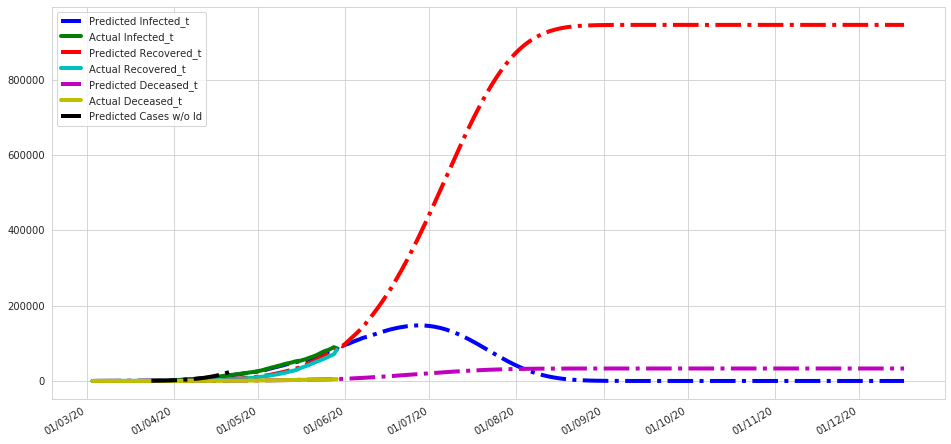

In [54]:
import matplotlib.dates as mdates
# weeks = mdates.WeekdayLocator()  # every month
datelocator = mdates.AutoDateLocator()
months_fmt = mdates.DateFormatter('%d/%m/%y')

    # Load a numpy structured array from yahoo csv data with fields date, open,
    # close, volume, adj_close from the mpl-data/example directory.  This array
    # stores the date as an np.datetime64 with a day unit ('D') in the 'date'
    # column.
    #with cbook.get_sample_data('goog.npz') as datafile:
     #   data = np.load(datafile)['price_data']

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(trial_2.Dates, trial_2.Xt,label ='Predicted Infected_t', color = 'b', linestyle = 'dashdot', linewidth = 4)
ax.plot(list(df.iloc[:bkwd_pred_range].Date),list(df.iloc[:bkwd_pred_range].infected_t),label ='Actual Infected_t', color = 'g', linestyle = 'solid', linewidth = 4)
ax.plot(trial_2.Dates,trial_2.Rt,label ='Predicted Recovered_t', color = 'r', linestyle = 'dashdot', linewidth = 4)
ax.plot(list(df.iloc[:bkwd_pred_range].Date),list(df.iloc[:bkwd_pred_range]['Total Recovered']),label ='Actual Recovered_t', color = 'c', linestyle = 'solid', linewidth = 4)
ax.plot(trial_2.Dates, trial_2.Dt,label ='Predicted Deceased_t', color = 'm', linestyle = 'dashdot', linewidth = 4)
ax.plot(list(df.iloc[:bkwd_pred_range].Date),list(df.iloc[:bkwd_pred_range]['Total Deceased']),label ='Actual Deceased_t', color = 'y', linestyle = 'solid', linewidth = 4)
ax.plot(w_l_pred.iloc[1:].Dates,w_l_pred.iloc[1:].Xt,label ='Predicted Cases w/o ld', color = 'black', linestyle = 'dashdot', linewidth = 4)
#     ax.plot(predicted_dates, predicted_counts,label = label2, color = 'g', linewidth = 2)
    # format the ticks
ax.xaxis.set_major_locator(datelocator)
ax.xaxis.set_major_formatter(months_fmt)
# ax.axvline(x=30)
# ax.xaxis.set_minor_locator(year)

    # round to nearest years.
    #datemin = np.datetime64(date_actual[1], 'Y')
    #datemax = np.datetime64(date_actual[len(date_actual)-1], 'Y') + np.timedelta64(1, 'Y')
    #ax.set_xlim(datemin, datemax)

    # format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    #ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
fig.autofmt_xdate()

plt.legend()
#     plt.title(title)

In [56]:
trial_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   289 non-null    object 
 1   Xt      289 non-null    float64
 2   Rt      289 non-null    float64
 3   Dt      289 non-null    float64
dtypes: float64(3), object(1)
memory usage: 9.2+ KB


In [60]:
trial_2 = trial_2.reset_index().drop('index',axis = 1)

In [61]:
trial_2.to_csv('Predicted_SIR_May_31.csv')

# MODULE 3.2:  POISSON REGRESSION: (SIR Predictions + Other Factor)

##  OVERVIEW

This notebook consist of the <b> Forecasting Module </b> of our Solution, This will consider the data from different sources, including the output of the <b> Markov Module </b> i.e the Stages at which a country is in a particular year. This notebook consist of following 6 Sections: 

<b> 1) Importing Packages  </b> <br> 
<b> 2) Loading Datasets and Preprocessing Steps  </b> <br>
<b> 3) ACF and PACF Plots for determine appropriate Lag  </b> <br> 
<b> 4) Data Visualization </b> <br>
<b> 5) Defining Utility Function for Data Modelling </b> <br>
<b> 6) Model Fitting and Results  </b> <br> 






## 1. IMPORTING PACKAGES

In [62]:
# Importing Packages

from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_error
import math

## 2. LOADING DATASETS AND PREPROCESSING STEPS 

In [65]:
# Reading the dataset

#India = pd.read_csv('../Data/12th May/India_final.csv')
SIR = pd.read_csv('Predicted_SIR_May_31.csv')
stages = pd.read_csv('Covid_cases_and_stages_May_31.csv')
print(stages.info())

## Dropping Unnecessary Columns
SIR.drop('Unnamed: 0', axis = 1,inplace = True)
stages.drop('Unnamed: 0',axis = 1, inplace = True)

## Merging the Dataset to Produce a Combined Datase
SIR = SIR.set_index('Dates')
stages = stages.set_index('Dates')
India = pd.merge(SIR, stages, how='outer',left_index=True,right_index=True)
India.reset_index(inplace=True)

## Removing Unnecessary Columns
India = India.dropna(axis=0, subset=['Xt'])
India = India.drop(['location', 'cum_day', 'new_tests','new_tests_per_thousand'], axis = 1)

India.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       120 non-null    int64  
 1   continent                        120 non-null    object 
 2   location                         120 non-null    object 
 3   cum_day                          120 non-null    int64  
 4   Dates                            120 non-null    object 
 5   total_cases                      120 non-null    float64
 6   new_cases                        120 non-null    float64
 7   total_deaths                     120 non-null    float64
 8   new_deaths                       120 non-null    float64
 9   total_cases_per_million          120 non-null    float64
 10  new_cases_per_million            120 non-null    float64
 11  total_deaths_per_million         120 non-null    float64
 12  new_deaths_per_million

,Dates,Xt,Rt,Dt,continent,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,total_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,stringency_index,life_expectancy,Stages
32,2020-03-04,3.213072,3.097414,0.011011,Asia,6.0,1.0,0.0,0.0,0.004,0.001,0.0,0.0,NaN,NaN,NaN,NaN,15.74,69.66,1.0
33,2020-03-05,26.784853,3.814626,0.091714,Asia,28.0,22.0,0.0,0.0,0.020,0.016,0.0,0.0,NaN,NaN,NaN,NaN,26.85,69.66,1.0
34,2020-03-06,28.916711,3.901171,0.099449,Asia,29.0,1.0,0.0,0.0,0.021,0.001,0.0,0.0,NaN,NaN,NaN,NaN,26.85,69.66,1.0
35,2020-03-07,29.977079,3.954885,0.103426,Asia,31.0,2.0,0.0,0.0,0.022,0.001,0.0,0.0,NaN,NaN,NaN,NaN,26.85,69.66,1.0
36,2020-03-08,33.183119,4.072661,0.114603,Asia,34.0,3.0,0.0,0.0,0.025,0.002,0.0,0.0,NaN,NaN,NaN,NaN,26.85,69.66,1.0


In [66]:
India['SIR_total_cases'] = India['Xt'] + India['Rt'] + India['Dt']

In [67]:
India['SIR_cases'] = India['SIR_total_cases'].diff().fillna(0)

In [68]:
India['SIR_cases']

32      0.000000
33     24.369696
34      2.226138
35      1.118058
36      3.334993
         ...    
316     0.000000
317     0.000000
318     0.000000
319     0.000000
320     0.000000
Name: SIR_cases, Length: 289, dtype: float64

#### Utility Functions

In [69]:
def adding_lagged_values(df, lag, label):
    data = list(df[label])
    lagged_data = []
    for i in range(lag):
        lagged_data.append(0)
    for i in range(lag, len(data)):
        lagged_data.append(data[i-lag])
    col_name = str('lagged_'+label)
    df[col_name] = lagged_data
    df.reset_index()
    return(df)

def impute_tests_data(total_tests, total_cases, round_digit, train_size):
    '''
    Imputing the Testing Data, with the moving average of past three data points, if past three data point are non
    zero, else with the last known value. 
    '''
    x = []
    imputed_total_tests = []
    j = 0
    
    for i, val in enumerate(total_tests):
        
        if math.isnan(val) and j==0:
            continue
        
        elif j==1:
            j = j+1
            for k in range(i+1):
                imputed_total_tests.append(round(np.mean(x)*total_cases[k],round_digit))
        
        elif math.isnan(val) and j>1:
            impute = np.mean(x[len(x)-3:])
            if math.isnan(impute):
                impute = np.mean(x[len(x)-2:])
                if math.isnan(impute):
                    impute = np.mean(x[len(x)-1:])
                else:
                    impute = np.mean(x)
            imputed_total_tests.append(round(impute*total_cases[i],round_digit))
        elif math.isnan(val) == False:
            x.append(val/total_cases[i])
            imputed_total_tests.append(val)
            j = j + 1
    
    imputed_total_tests = list(pd.Series(imputed_total_tests[:train_size]).rolling(3).mean().fillna(np.mean(imputed_total_tests[:2])))
    
    value = []
    for p in range(len(total_tests)):
        if p < train_size:
            value.append(round(imputed_total_tests[p],round_digit))
        else:
            value.append(math.nan)
    return(value)

In [70]:
#################################################################################
#################### Adding Lagged Values to the Dataset ########################
#################################################################################

## Adding some Lagged Columns
India = adding_lagged_values(India, 14, 'stringency_index')
India = adding_lagged_values(India, 14, 'new_cases')

##################################################################################
#################### Imputing the Missing Data in Training Set ###################
##################################################################################

## Initializing the Series to be Imputed
total_tests = (India.total_tests)
total_cases = list(India.total_cases)
new_tests = India.new_tests_smoothed
new_cases = list(India.new_cases)
total_tests_per_thousand = (India.total_tests_per_thousand)
new_tests_per_thousand = (India.new_tests_smoothed_per_thousand)
train_size = len(India.total_cases.dropna())

print('Training Dataset Size is', train_size)
      
## Applying Functions
total_tests = impute_tests_data(total_tests, total_cases,0, train_size)
new_tests = impute_tests_data(new_tests, new_cases,0, train_size)
new_tests_per_thousand = impute_tests_data(new_tests_per_thousand, new_cases,3,train_size)
total_tests_per_thousand = impute_tests_data(new_tests_per_thousand, new_cases,3, train_size)

## Adding Imputed Values to the India Dataframe 
cols = ['total_tests','new_tests_smoothed','total_tests_per_thousand','new_tests_smoothed_per_thousand']
imputed_vals = [total_tests, new_tests, total_tests_per_thousand, new_tests_per_thousand]
India = India.drop(cols, axis = 1)
for i in range(4):
    India[cols[i]] = imputed_vals[i]

Training Dataset Size is 88


In [71]:
India.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 32 to 320
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Dates                            289 non-null    object 
 1   Xt                               289 non-null    float64
 2   Rt                               289 non-null    float64
 3   Dt                               289 non-null    float64
 4   continent                        88 non-null     object 
 5   total_cases                      88 non-null     float64
 6   new_cases                        88 non-null     float64
 7   total_deaths                     88 non-null     float64
 8   new_deaths                       88 non-null     float64
 9   total_cases_per_million          88 non-null     float64
 10  new_cases_per_million            88 non-null     float64
 11  total_deaths_per_million         88 non-null     float64
 12  new_deaths_per_millio

In [72]:
India.head(132)

,Dates,Xt,Rt,Dt,continent,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,...,life_expectancy,Stages,SIR_total_cases,SIR_cases,lagged_stringency_index,lagged_new_cases,total_tests,new_tests_smoothed,total_tests_per_thousand,new_tests_smoothed_per_thousand
32,2020-03-04,3.213072,3.097414,0.011011,Asia,6.0,1.0,0.0,0.0,0.004,...,69.66,1.0,6.321498,0.000000,0.0,0.0,3510.0,584.0,0.001,0.001
33,2020-03-05,26.784853,3.814626,0.091714,Asia,28.0,22.0,0.0,0.0,0.020,...,69.66,1.0,30.691193,24.369696,0.0,0.0,3510.0,584.0,0.001,0.001
34,2020-03-06,28.916711,3.901171,0.099449,Asia,29.0,1.0,0.0,0.0,0.021,...,69.66,1.0,32.917331,2.226138,0.0,0.0,3149.0,707.0,0.008,0.001
35,2020-03-07,29.977079,3.954885,0.103426,Asia,31.0,2.0,0.0,0.0,0.022,...,69.66,1.0,34.035389,1.118058,0.0,0.0,1820.0,346.0,0.008,0.000
36,2020-03-08,33.183119,4.072661,0.114603,Asia,34.0,3.0,0.0,0.0,0.025,...,69.66,1.0,37.370382,3.334993,0.0,0.0,2542.0,361.0,0.008,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,2020-07-09,131137.512680,574987.233907,24522.452593,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,730647.199180,14431.056838,NaN,NaN,NaN,NaN,NaN,NaN
160,2020-07-10,128218.516189,591545.092331,25001.611452,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,744765.219972,14118.020792,NaN,NaN,NaN,NaN,NaN,NaN
161,2020-07-11,125089.540554,607985.960268,25469.077180,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,758544.578003,13779.358031,NaN,NaN,NaN,NaN,NaN,NaN
162,2020-07-12,121769.108441,624268.589410,25924.134293,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,771961.832145,13417.254142,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
India.describe()

,Xt,Rt,Dt,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,...,life_expectancy,Stages,SIR_total_cases,SIR_cases,lagged_stringency_index,lagged_new_cases,total_tests,new_tests_smoothed,total_tests_per_thousand,new_tests_smoothed_per_thousand
count,2.890000e+02,289.000000,289.000000,88.000000,88.00000,88.000000,88.000000,88.000000,88.000000,88.000000,...,8.800000e+01,88.000000,289.000000,289.000000,102.000000,102.000000,8.800000e+01,88.000000,88.000000,88.000000
mean,3.272325e+04,554608.583269,20448.287400,38201.795455,2069.75000,1170.863636,58.681818,27.682330,1.499830,0.848455,...,6.966000e+01,2.170455,607780.116926,3384.518014,70.020980,1785.666667,7.706073e+05,34525.636364,0.023580,0.025045
std,4.840481e+04,420196.112865,14347.399494,50010.719996,2340.84501,1477.650101,62.463699,36.239561,1.696268,1.070775,...,8.575376e-14,1.085130,422026.518571,5116.643153,35.494607,2287.425131,9.872068e+05,36886.129624,0.025589,0.026729
min,-2.174823e-31,3.097414,0.011011,6.000000,1.00000,0.000000,0.000000,0.004000,0.001000,0.000000,...,6.966000e+01,1.000000,6.321498,-0.079935,0.000000,0.000000,1.820000e+03,87.000000,0.000000,0.000000
25%,1.484694e-04,34061.402930,2840.039470,705.250000,91.25000,16.000000,3.000000,0.511250,0.066250,0.011250,...,6.966000e+01,1.000000,87892.705114,0.000000,48.150000,22.250000,2.155925e+04,1477.750000,0.001000,0.001000
50%,1.864073e+03,818048.176038,30725.978022,13882.500000,1143.00000,458.500000,37.000000,10.060000,0.828500,0.332500,...,6.966000e+01,2.000000,912835.950066,202.543891,81.940000,784.500000,2.599155e+05,19753.500000,0.011500,0.014500
75%,5.288308e+04,945033.107564,33098.919947,60481.250000,3534.00000,2013.000000,100.750000,43.826750,2.560500,1.459000,...,6.966000e+01,3.000000,978132.027603,5123.227383,100.000000,3197.250000,1.295867e+06,72544.250000,0.046750,0.052500
max,1.475045e+05,945033.107655,33098.919948,182143.000000,8380.00000,5164.000000,265.000000,131.987000,6.072000,3.742000,...,6.966000e+01,4.000000,978132.605321,15968.238002,100.000000,8380.000000,3.362711e+06,106685.000000,0.076000,0.077000


## 4. DATA VISUALIZATION

In [74]:
def date_conversion(date_string):
    datetime_object = datetime.strptime(date_string, '%Y-%m-%d')
    return datetime_object.date()

India['Date']= India.apply(lambda row: date_conversion(row.Dates), axis = 1)

In [75]:
# Plotting the Confirmed Cases with Date
import matplotlib.pyplot as plt

def plot_data(df, label1, interval1):
    
    weeks = mdates.DayLocator(interval = interval1)  # every month
    months_fmt = mdates.DateFormatter('%d/%m/%y')
    
    dates = df['Date']
    values = df[label1]


    fig, ax = plt.subplots()
    ax.plot(dates, values,label =label1, color = 'b', linestyle = 'dashdot', linewidth = 4)
    # ax.plot(predicted_dates, predicted_counts,label = label2, color = 'g', linewidth = 2)
    
    # format the ticks
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(months_fmt)
    
    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.


    fig.autofmt_xdate()

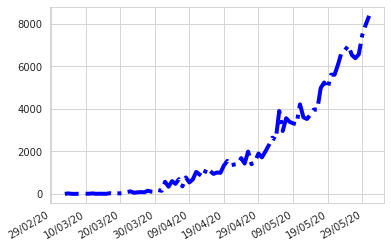

In [76]:
plot_data(India, 'new_cases',10)

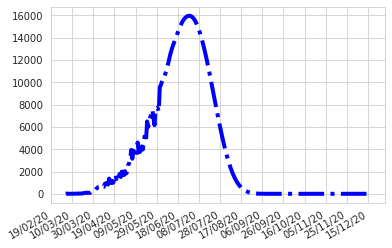

In [77]:
plot_data(India, 'SIR_cases',20)

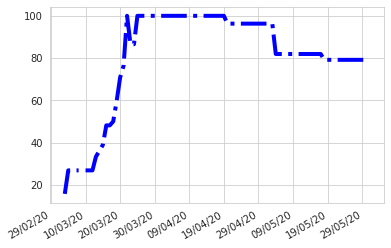

In [78]:
plot_data(India, 'stringency_index',10)

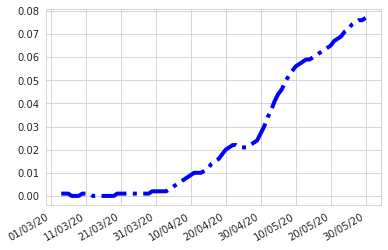

In [79]:
plot_data(India, 'new_tests_smoothed_per_thousand',10)

## PLOTTING THE CORRELATION GRAPH

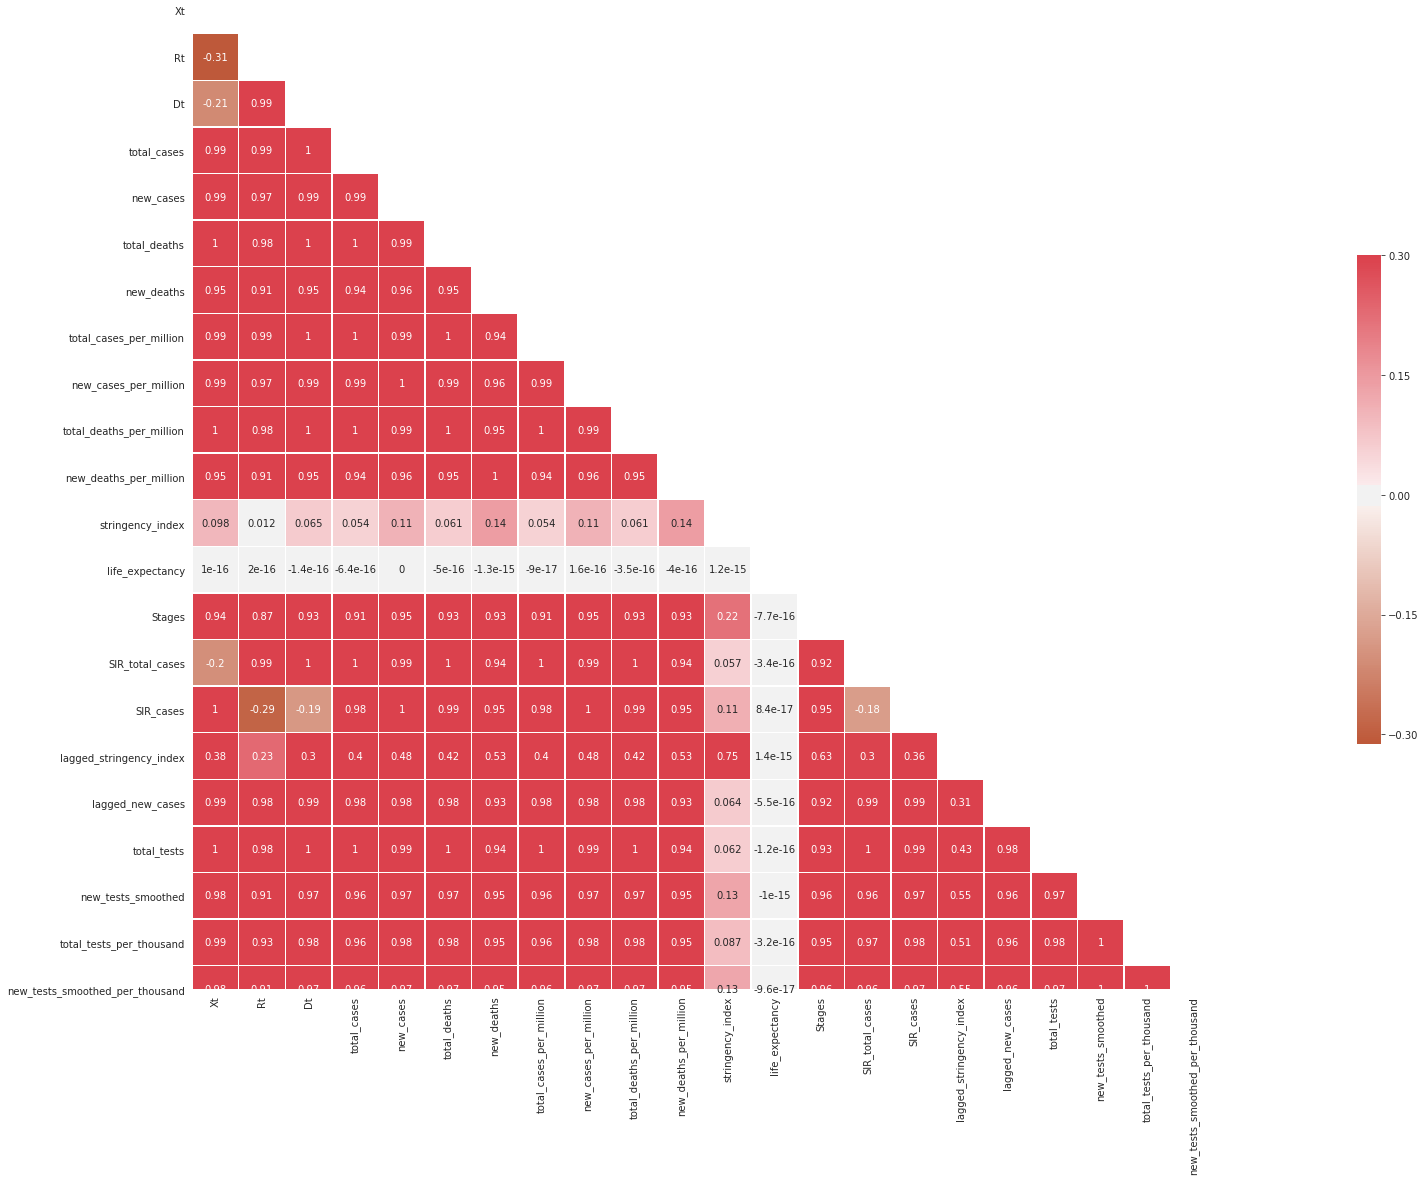

In [80]:
# Compute the correlation matrix
corr = India.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(50, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(22, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot = True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [81]:
India.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 32 to 320
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Dates                            289 non-null    object 
 1   Xt                               289 non-null    float64
 2   Rt                               289 non-null    float64
 3   Dt                               289 non-null    float64
 4   continent                        88 non-null     object 
 5   total_cases                      88 non-null     float64
 6   new_cases                        88 non-null     float64
 7   total_deaths                     88 non-null     float64
 8   new_deaths                       88 non-null     float64
 9   total_cases_per_million          88 non-null     float64
 10  new_cases_per_million            88 non-null     float64
 11  total_deaths_per_million         88 non-null     float64
 12  new_deaths_per_millio

## 5. DEFINITION OF UTILITY FUNCTIONS FOR MODELLING DATA

In [82]:
## Expressions for New_cases
expr0 = '''new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases'''
expr1 = '''new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases + stringency_index + total_tests_per_thousand + new_tests_smoothed'''
expr2 = '''new_cases ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed'''
expr3 = '''new_cases ~ Stages + lagged_stringency_index + new_tests_smoothed'''

# Expressions for New_deaths
expr4 = '''new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases'''
expr5 = '''new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand + new_tests_smoothed'''
expr6 = '''new_deaths ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed'''
expr7 = '''new_deaths ~ Stages + lagged_stringency_index + new_tests_smoothed'''


def train_test_split(df,ratio, expr):
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_test = df[~mask]
    print('Training data set length='+str(len(df_train)))
    print('Testing data set length='+str(len(df_test)))

    ## Matrix Formation
    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
    return X_train, y_train, X_test, y_test

    
def train_test_future_split(df, expr, training_size, prediction_size):
    df_train = df.head(training_size)
    test_size = training_size + prediction_size
    df_test = df.head(test_size)

    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
    return X_train, y_train, X_test, y_test

def train_model(y_train, X_train):
    model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    print(model.summary())
    return(model)

def predict(model, X_test):
    poisson_predictions = model.get_prediction(X_test)
    #.summary_frame() returns a pandas DataFrame
    predictions_summary_frame = poisson_predictions.summary_frame()
    print(predictions_summary_frame)
    return(predictions_summary_frame['mean'])
    
    
def plot_results(predictions_summary_frame,X_test, y_test, country, label):
    predicted_counts=predictions_summary_frame
    actual_counts = y_test[label]
    fig = plt.figure()
    fig.suptitle(str('Predicted Mean of Covid 19 Cofirmed Cases Count'))
    predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
    actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
    plt.legend(handles=[predicted, actual])
    plt.show()
    return(predicted_counts, actual_counts)

def plot_results_1(predictions_summary_frame,X_train, y_train, X_test, y_test, country, label1):
    predicted_counts=predictions_summary_frame
    actual_counts = y_train[label1]    
    fig = plt.figure()
    fig.suptitle(str('Predicted Mean of Covid 19 '+label1))
    predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
    actual, = plt.plot(X_train.index, actual_counts, 'ro-', label='Actual counts')
    #SIR, = plt.plot(X_test.index, I_x, 'bo-', label='SIR Predictions')
    #Wt_predictions, = plt.plot(X_test.index, avg, 'yo-',label = 'Weighted Predictions')
    plt.legend(handles=[predicted, actual])
    plt.show()
    return(predicted_counts, actual_counts)
    
def plot_actual_vs_output(predicted_counts, actual_counts):
    plt.clf()
    fig = plt.figure()
    fig.suptitle('Scatter plot of Actual versus Predicted counts')
    plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
    plt.xlabel('Predicted counts')
    plt.ylabel('Actual counts')
    plt.show()

## 6. NEW CASES MODEL: TRAINING AND RESULTS

## STEP 1: TEST-TRAIN SPLIT

In [83]:
X_train, y_train, X_test, y_test = train_test_split(India, 0.9,expr1) 
#X_future, y_future, p, q = train_test_split(India_future,1, expr)

Training data set length=260
Testing data set length=29


## STEP 2: MODEL TRAINING AND SUMMARY

In [84]:
model = train_model(y_train, X_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                   77
Model:                            GLM   Df Residuals:                       68
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3914.0
Date:                Sat, 18 Jul 2020   Deviance:                       7208.6
Time:                        11:50:34   Pearson chi2:                 6.85e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

## STEP 3: PREDICTIONS

In [85]:
predictions_frame = (predict(model, X_test)).rolling(1).mean().fillna(0)
# predictions_frame = predictions_frame.fillna(0)

            mean    mean_se  mean_ci_lower  mean_ci_upper
33     11.633852   0.660286      10.409098      13.002713
43     20.710889   0.996391      18.847244      22.758815
65    643.081051   5.571949     632.252439     654.095126
66    462.793389   4.487461     454.081176     471.672759
75    968.142723   6.199617     956.067631     980.370322
82   1138.918416  10.149696    1119.198102    1158.986202
84   1013.128463  10.083808     993.556090    1033.086399
87   1199.258318  10.229180    1179.376148    1219.475666
101  3917.113163  32.016885    3854.861188    3980.370441


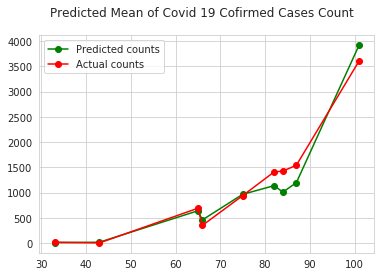

<function mean_squared_error at 0x7f046eeb5ea0> 287355923055.1976
<function r2_score at 0x7f046e6fa158> 0.9511496680283277
<function median_absolute_error at 0x7f046e6fa048> 253217.3481341343
<function mean_absolute_error at 0x7f046eeb5e18> 401298.38658845075


In [86]:
predicted_counts, actual_counts = plot_results(predictions_frame, X_test, y_test.rolling(1).mean().fillna(0), India, 'new_cases')
scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
for i in scores: 
    print(i, i(actual_counts*np.std(India['new_cases']),predicted_counts*np.std(India['new_cases'])))

## New Cases

In [87]:

## Expressions for New_cases
expr0 = '''new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases'''
expr1 = '''new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand'''
expr2 = '''new_cases ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed'''
expr3 = '''new_cases ~ Stages + lagged_stringency_index + new_tests_smoothed'''
expr4 = '''new_cases ~ Xt + Stages + lagged_stringency_index + new_tests_smoothed'''

Training data set length=76
Testing data set length=12
                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                   76
Model:                            GLM   Df Residuals:                       70
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8362.1
Date:                Sat, 18 Jul 2020   Deviance:                       16117.
Time:                        11:50:38   Pearson chi2:                 1.39e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

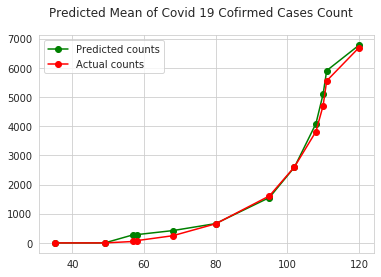

<function mean_squared_error at 0x7f046eeb5ea0> 41190.063362694986
<function r2_score at 0x7f046e6fa158> 0.9924904293495916
<function median_absolute_error at 0x7f046e6fa048> 130.25991966712945
<function mean_absolute_error at 0x7f046eeb5e18> 149.48134635034114
Training data set length=67
Testing data set length=21
                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                   67
Model:                            GLM   Df Residuals:                       59
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1753.4
Date:                Sat, 18 Jul 2020   Deviance:                       2959.2
Time:                        11:50:38   Pearson chi2:                 2.85e+03
No. Iterations:                     8              

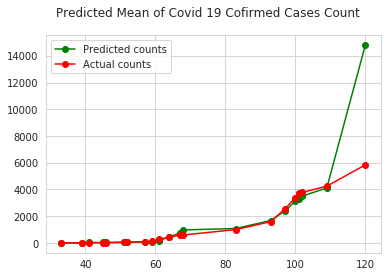

<function mean_squared_error at 0x7f046eeb5ea0> 3845844.769457021
<function r2_score at 0x7f046e6fa158> -0.252243510013477
<function median_absolute_error at 0x7f046e6fa048> 78.5643747653196
<function mean_absolute_error at 0x7f046eeb5e18> 531.9790068830744
Training data set length=58
Testing data set length=30
                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                   58
Model:                            GLM   Df Residuals:                       51
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1685.1
Date:                Sat, 18 Jul 2020   Deviance:                       2899.0
Time:                        11:50:39   Pearson chi2:                 2.69e+03
No. Iterations:                     7                  

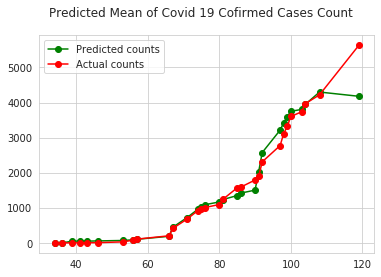

<function mean_squared_error at 0x7f046eeb5ea0> 93056.297731092
<function r2_score at 0x7f046e6fa158> 0.9615681901900011
<function median_absolute_error at 0x7f046e6fa048> 51.20750455908782
<function mean_absolute_error at 0x7f046eeb5e18> 148.59680762486155
Training data set length=77
Testing data set length=11
                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                   77
Model:                            GLM   Df Residuals:                       73
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5462.9
Date:                Sat, 18 Jul 2020   Deviance:                       10304.
Time:                        11:50:39   Pearson chi2:                 9.78e+03
No. Iterations:                     7                  

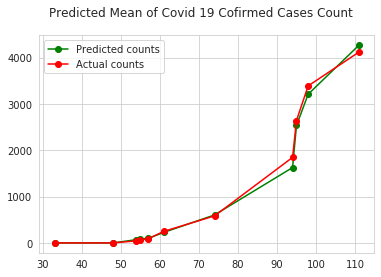

<function mean_squared_error at 0x7f046eeb5ea0> 10605.964045250877
<function r2_score at 0x7f046e6fa158> 0.995113270043425
<function median_absolute_error at 0x7f046e6fa048> 25.838058752368973
<function mean_absolute_error at 0x7f046eeb5e18> 69.03362391747622
Training data set length=73
Testing data set length=15
                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                   73
Model:                            GLM   Df Residuals:                       68
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2279.0
Date:                Sat, 18 Jul 2020   Deviance:                       3983.1
Time:                        11:50:39   Pearson chi2:                 3.90e+03
No. Iterations:                     7                

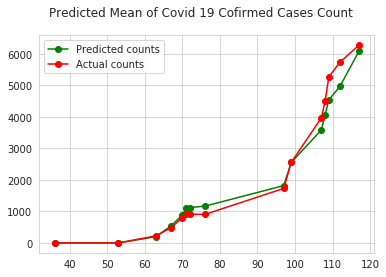

<function mean_squared_error at 0x7f046eeb5ea0> 111205.07915720661
<function r2_score at 0x7f046e6fa158> 0.9764334328967457
<function median_absolute_error at 0x7f046e6fa048> 191.11667830307226
<function mean_absolute_error at 0x7f046eeb5e18> 229.1049784133021


In [88]:
expressions = [expr0, expr1, expr2, expr3, expr4]
rmse = dict()
r2_Score = dict()
mae = dict()
for exp in expressions:
    India_filtered = India[India['total_cases']>0].fillna(0)
    X_train, y_train, X_test, y_test = train_test_split(India_filtered,0.8, exp) 
    model = train_model(y_train, X_train)
    predictions_frame = (predict(model, X_test)).rolling(3).mean().fillna(0)
    predicted_counts, actual_counts = plot_results(predictions_frame,X_test, y_test.rolling(3).mean().fillna(0), India, 'new_cases')
    scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
    for i in scores: 
        print(i, i(actual_counts,predicted_counts))
    rmse[exp] = np.sqrt(mean_squared_error(actual_counts,predicted_counts))
    r2_Score[exp] = r2_score(actual_counts,predicted_counts)
    mae[exp] = mean_absolute_error(actual_counts, predicted_counts)

In [89]:
for i in rmse.keys():
    print(i, rmse[i])

new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases 202.9533526766557
new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand 1961.0825503932824
new_cases ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed 305.0513034410638
new_cases ~ Stages + lagged_stringency_index + new_tests_smoothed 102.98526130107588
new_cases ~ Xt + Stages + lagged_stringency_index + new_tests_smoothed 333.47425561384284


In [234]:
for i in mae.keys():
    print(i, mae[i])

new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases 289.93412057397796
new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand 216.0885232254715
new_cases ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed 296.40947417298355
new_cases ~ Stages + lagged_stringency_index + new_tests_smoothed 871.0865195361355
new_cases ~ Xt + Stages + lagged_stringency_index + new_tests_smoothed 276.6427971063781


In [235]:
for i in r2_Score.keys():
    print(i, r2_Score[i])

new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases 0.9910972246803511
new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand 0.9943315599388277
new_cases ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed 0.9899934996442058
new_cases ~ Stages + lagged_stringency_index + new_tests_smoothed 0.8463282888193283
new_cases ~ Xt + Stages + lagged_stringency_index + new_tests_smoothed 0.9907659514328874


## New Deaths

In [354]:
# Expressions for New_deaths
expr4 = '''new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + SIR_cases + lagged_stringency_index'''
expr5 = '''new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand + new_tests_smoothed'''
expr6 = '''new_deaths ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed'''
expr7 = '''new_deaths ~ Stages + lagged_stringency_index + new_tests_smoothed'''


Training data set length=80
Testing data set length=38
                 Generalized Linear Model Regression Results                  
Dep. Variable:             new_deaths   No. Observations:                   80
Model:                            GLM   Df Residuals:                       72
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -984.20
Date:                Sat, 18 Jul 2020   Deviance:                       1564.1
Time:                        10:55:02   Pearson chi2:                 1.52e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

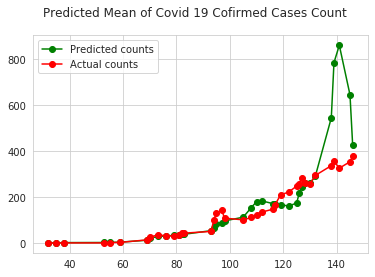

<function mean_squared_error at 0x7fcaa59bd9d8> 16583.02904040379
<function r2_score at 0x7fcaa59bdbf8> -0.13423907011861336
<function median_absolute_error at 0x7fcaa59bdae8> 9.087100777814326
<function mean_absolute_error at 0x7fcaa59bd950> 56.58396278073622
Training data set length=77
Testing data set length=41
                 Generalized Linear Model Regression Results                  
Dep. Variable:             new_deaths   No. Observations:                   77
Model:                            GLM   Df Residuals:                       68
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1593.5
Date:                Sat, 18 Jul 2020   Deviance:                       2775.2
Time:                        10:55:02   Pearson chi2:                 3.40e+03
No. Iterations:                     8               

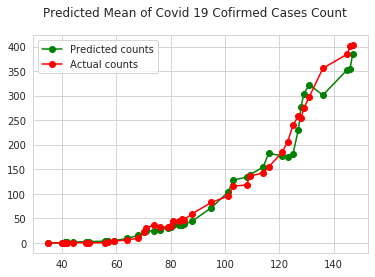

<function mean_squared_error at 0x7fcaa59bd9d8> 388.0969876922538
<function r2_score at 0x7fcaa59bdbf8> 0.9753331771359991
<function median_absolute_error at 0x7fcaa59bdae8> 8.38478895945591
<function mean_absolute_error at 0x7fcaa59bd950> 13.236557157477348
Training data set length=84
Testing data set length=34
                 Generalized Linear Model Regression Results                  
Dep. Variable:             new_deaths   No. Observations:                   84
Model:                            GLM   Df Residuals:                       77
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -407.83
Date:                Sat, 18 Jul 2020   Deviance:                       390.70
Time:                        10:55:03   Pearson chi2:                     407.
No. Iterations:                     8                 

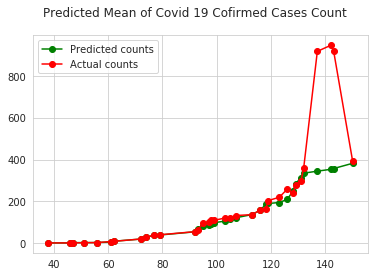

<function mean_squared_error at 0x7fcaa59bd9d8> 29632.09909365685
<function r2_score at 0x7fcaa59bdbf8> 0.5350259690806779
<function median_absolute_error at 0x7fcaa59bdae8> 9.492918805526614
<function mean_absolute_error at 0x7fcaa59bd950> 59.289318547355386
Training data set length=87
Testing data set length=31
                 Generalized Linear Model Regression Results                  
Dep. Variable:             new_deaths   No. Observations:                   87
Model:                            GLM   Df Residuals:                       83
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2853.2
Date:                Sat, 18 Jul 2020   Deviance:                       5229.8
Time:                        10:55:03   Pearson chi2:                 9.17e+03
No. Iterations:                     7                

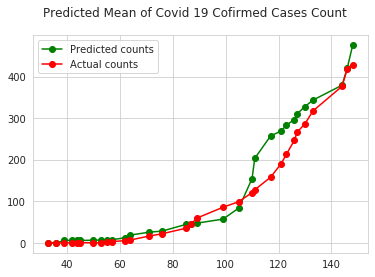

<function mean_squared_error at 0x7fcaa59bd9d8> 1250.172324653114
<function r2_score at 0x7fcaa59bdbf8> 0.9326052747587739
<function median_absolute_error at 0x7fcaa59bdae8> 9.145575958274748
<function mean_absolute_error at 0x7fcaa59bd950> 23.16105256259826


In [355]:
expressions = [expr4, expr5, expr6, expr7]
rmse = dict()
r2_Score = dict()
mae = dict()
for exp in expressions:
    India_filtered = India[India['total_cases']>0].fillna(0)
    X_train, y_train, X_test, y_test = train_test_split(India_filtered,0.7, exp) 
    model = train_model(y_train, X_train)
    predictions_frame = (predict(model, X_test)).rolling(3).mean().fillna(0)
    predicted_counts, actual_counts = plot_results(predictions_frame,X_test, y_test.rolling(3).mean().fillna(0), India, 'new_deaths')
    scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
    for i in scores: 
        print(i, i(actual_counts,predicted_counts))
    rmse[exp] = np.sqrt(mean_squared_error(actual_counts,predicted_counts))
    r2_Score[exp] = r2_score(actual_counts,predicted_counts)
    mae[exp] = mean_absolute_error(actual_counts, predicted_counts)

In [356]:
for i in rmse.keys():
    print(i,': ', round(rmse[i],4))

new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + SIR_cases + lagged_stringency_index :  128.7751
new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand + new_tests_smoothed :  19.7002
new_deaths ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed :  172.1398
new_deaths ~ Stages + lagged_stringency_index + new_tests_smoothed :  35.3578


In [357]:
for i in mae.keys():
    print(i, round(mae[i],4))

new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + SIR_cases + lagged_stringency_index 56.584
new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand + new_tests_smoothed 13.2366
new_deaths ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed 59.2893
new_deaths ~ Stages + lagged_stringency_index + new_tests_smoothed 23.1611


In [358]:
for i in r2_Score.keys():
    print(i, round(r2_Score[i]))

new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + SIR_cases + lagged_stringency_index -0.0
new_deaths ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index + total_tests_per_thousand + new_tests_smoothed 1.0
new_deaths ~ Xt + Rt + Dt + Stages + lagged_stringency_index + new_tests_smoothed 1.0
new_deaths ~ Stages + lagged_stringency_index + new_tests_smoothed 1.0


# Predicting for Future

## New COVID Cases

In [90]:
def prepare_future_data(df_test,train_size ,prediction_size):
    
    df_test= India.head(train_size+prediction_size)
    
    if prediction_size>0:
        cols = ['total_tests','new_tests_smoothed','total_tests_per_thousand','new_tests_smoothed_per_thousand','stringency_index']
        
        for col in cols:
            val = (India[col].dropna()).tolist()
            x = df_test[col].fillna(val[-1])
            df_test = df_test.drop(col, axis=1)
            df_test[col] = x
    
    ## Generating New Stages
    Stages = list(df_test.Stages)[:train_size]
    last = int(Stages[-1])
    sec_last = int(Stages[-2])
    arr = getStages(fpt, sec_last,last, prediction_size)
    
    for i in range(prediction_size):
        Stages.append(arr[i])
    
    print(len(Stages))
    df_test = df_test.drop('Stages',axis = 1)
    df_test['Stages'] = Stages
    
    ## New_cases_filling na
    new_cases = list(df_test.new_cases.fillna(0))
    df_test =df_test.drop('new_cases', axis = 1)
    df_test['new_cases'] = new_cases
    df_test = df_test.fillna(0)
    return(df_test)

## STEP 1: TEST-TRAIN SPLIT

## Add the number of days for which you have to predict in future

In [122]:
expr1 = '''new_cases ~ stringency_index + Stages + SIR_cases '''
expr7 = '''new_deaths ~ Stages + lagged_stringency_index + new_tests_smoothed'''

In [123]:
print("Size of the Dataset we have for India:", train_size)

Size of the Dataset we have for India: 88


In [137]:
train_size_1 = 88  ## Till 31st May 
train_size_2 = 119  ## Till 30th June

India_filtered_1 = India.head(train_size_1)
India_filtered_2 = India.head(train_size_2)

## Number of Days you have to predict in future
prediction_days = 100
India_future = prepare_future_data(India_filtered_1, train_size_1, prediction_days)

## Splitting the dataset into Test and Train for Daily Cases
X_train, y_train, X_test, y_test = train_test_split(India_filtered_1,1, expr1) 
X_India, y_India, p, q = train_test_split(India_future,1, expr1)

## Splitting the dataset into Test and Train for Daily Deaths
X_train_d, y_train_d, X_test_d, y_test_d = train_test_split(India_filtered_1,1, expr7) 
X_India_d, y_India_d, p_d, q_d = train_test_split(India_future,1, expr7)

188
Training data set length=88
Testing data set length=0
Training data set length=188
Testing data set length=0
Training data set length=88
Testing data set length=0
Training data set length=188
Testing data set length=0


In [138]:
(X_India.head(130))

,Intercept,stringency_index,Stages,SIR_cases
32,1.0,15.74,1.0,0.000000
33,1.0,26.85,1.0,24.369696
34,1.0,26.85,1.0,2.226138
35,1.0,26.85,1.0,1.118058
36,1.0,26.85,1.0,3.334993
...,...,...,...,...
157,1.0,79.17,3.0,14976.470430
158,1.0,79.17,3.0,14716.958459
159,1.0,79.17,3.0,14431.056838
160,1.0,79.17,3.0,14118.020792


## STEP 2: MODEL TRAINING AND SUMMARY

In [139]:
model = train_model(y_train, X_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                   87
Model:                            GLM   Df Residuals:                       83
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10215.
Date:                Sat, 18 Jul 2020   Deviance:                       19733.
Time:                        15:29:39   Pearson chi2:                 1.87e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.7717      0.038  

In [127]:
model_d = train_model(y_train_d, X_train_d)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             new_deaths   No. Observations:                   86
Model:                            GLM   Df Residuals:                       82
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -379.14
Date:                Sat, 18 Jul 2020   Deviance:                       373.52
Time:                        13:53:16   Pearson chi2:                     380.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [128]:
X_India.to_csv('training_data.csv')

## STEP 3: PREDICTIONS

In [140]:
predictions_frame = (predict(model, X_India)).rolling(5).mean().fillna(0)
# predictions_frame = predictions_frame.fillna(0)

           mean   mean_se  mean_ci_lower  mean_ci_upper
32    55.126711  1.673649      51.942107      58.506564
33    72.798819  1.925521      69.121021      76.672306
34    72.622115  1.921478      68.952070      76.487502
35    72.613284  1.921276      68.943625      76.478266
36    72.630953  1.921680      68.960521      76.496745
..          ...       ...            ...            ...
215  265.862556  2.567210     260.878232     270.942111
216  265.779927  2.566123     260.797707     270.857326
217  265.718548  2.565317     260.737889     270.794348
218  265.673658  2.564728     260.694140     270.748290
219  265.641395  2.564306     260.662696     270.715189

[188 rows x 4 columns]


In [130]:
Results = pd.DataFrame()

dates = list(whole_data[whole_data['Dates']>=pd.to_datetime('2020-05-31')]['Dates'][:14])
actual = list(whole_data[whole_data['Dates']>=pd.to_datetime('2020-05-31')]['new_cases'])[:14]
predicted = (predictions_frame[-14:])
SIR = X_India.tail(14)
sir = list(SIR['SIR_cases'])
print(len(actual), len(predicted), len(sir))

Results['Dates'] = dates
Results['Actual Counts'] = actual
Results['Poisson Predictions'] = predicted.values
Results['SIR Predictions'] = sir


RMSE_SIR = np.sqrt(mean_squared_error(actual, sir))
MAE_SIR = mean_absolute_error(actual, sir)
RMSE_Poisson = np.sqrt(mean_squared_error(actual, predicted))
MAE_Poisson = mean_absolute_error(actual, predicted)

print("Percentage Root Mean Square Error for SIR               :", round(RMSE_SIR/np.mean(actual),3))
print("Percentage Root Mean Square Error for Poisson Regression:", round(RMSE_Poisson/np.mean(actual),3))
print("Percentage Mean Absolute Error for SIR                  :", round(MAE_SIR/np.mean(actual),3))
print("Percentage Mean Absolute Error for Poisson Regression   :", round(MAE_Poisson/np.mean(actual),3))

14 14 14
Percentage Root Mean Square Error for SIR               : 0.126
Percentage Root Mean Square Error for Poisson Regression: 0.097
Percentage Mean Absolute Error for SIR                  : 0.116
Percentage Mean Absolute Error for Poisson Regression   : 0.081


In [150]:
def plot_data(dates,actual,predicted,sir, interval1):
    
    weeks = mdates.DayLocator(interval = interval1)  # every month
    months_fmt = mdates.DateFormatter('%d/%m/%y')
    
    # dates = df['Date']
    # values = df[label1]
    dates1 = pd.Series(dates)
    dates2 = pd.Series(dates[:len(actual)])
    dates3 = pd.Series(dates[:len(sir)])
    
    label1 = 'Actual Cases'
    label2 = 'Poisson Regression Predictions'
    label3 = "SIR Predictions"

    fig, ax = plt.subplots(figsize = (15,5))
    ax.plot(dates2, pd.Series(actual).rolling(2).mean(),label =label1, color = 'b', linestyle = 'dashdot', linewidth = 4)
    ax.plot(dates1, predicted,label = label2, color = 'g', linewidth = 2)
    ax.plot(dates3, sir,label = label3, color = 'r', linewidth = 2)
    
    # format the ticks
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(months_fmt)
    
    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    
    plt.legend()
    plt.title('Predictions for Next 15 Days')


    fig.autofmt_xdate()
    
#plot_data(dates, actual, predicted,sir, 3)

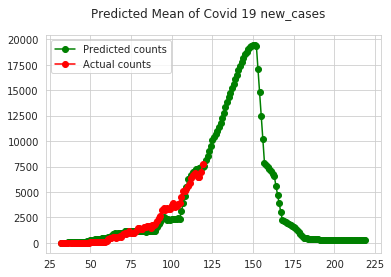

In [144]:
predicted_counts, actual_counts = plot_results_1(predictions_frame,X_train, y_train.rolling(2).mean().fillna(0),X_India, y_India, India, 'new_cases')


In [151]:
dates = list(India_future.Dates)
dates = [pd.to_datetime(dates[i]) for i in range(len(India_future))]
sir = list(India_future.SIR_cases)
dates_actual = dates[:len(actual_counts)]
print(len(predicted_counts), len(actual_counts),len(sir))

188 87 188


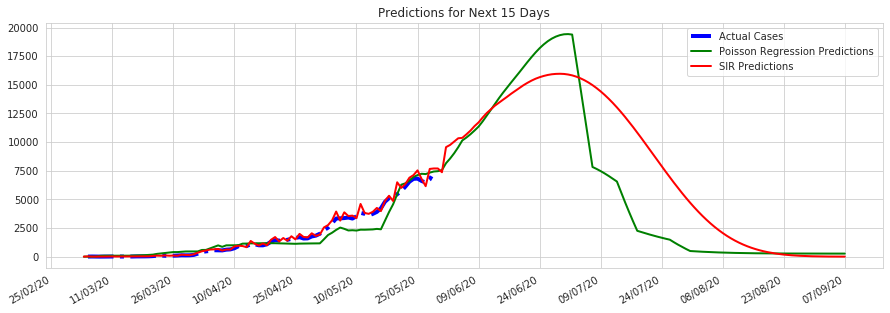

In [152]:
plot_data(dates, actual_counts, predicted_counts, sir, 15)

In [146]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [134]:
def plot_results_final(acutal_dates, actual_counts, predicted_dates, predicted_counts, label1, label2, title):
    # months = mdates.MonthLocator()   # every year
    weeks = mdates.WeekdayLocator()  # every month
    months_fmt = mdates.DateFormatter('%d/%m/%y')

    fig, ax = plt.subplots()
    ax.plot(actual_dates, actual_counts,label =label1, color = 'b', linestyle = 'dashdot', linewidth = 4)
    ax.plot(predicted_dates, predicted_counts,label = label2, color = 'g', linewidth = 2)
    
    # format the ticks
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(months_fmt)
    
    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    #ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()

    plt.legend()
    plt.title(title)
    plt.show()


182143
14 14 14 14
Percentage Root Mean Square Error for SIR               : 0.02307
Percentage Root Mean Square Error for Poisson Regression: 0.01038
Percentage Mean Absolute Error for SIR                  : 0.01713
Percentage Mean Absolute Error for Poisson Regression   : 0.00895


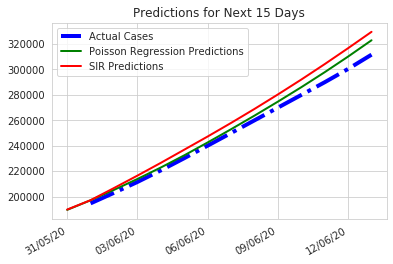

In [136]:
###################################################################
#############  Cumulative Cases Counts ############################
###################################################################
cumm_actual_counts= []
counts = int(whole_data[whole_data['Dates']==pd.to_datetime('2020-05-31')]['total_cases'])
print(counts)
for i in actual:
    counts += i
    cumm_actual_counts.append(counts)
    
cumm_poisson_counts = []
counts = int(whole_data[whole_data['Dates']==pd.to_datetime('2020-05-31')]['total_cases'])
for i in predicted:
    counts+=i
    cumm_poisson_counts.append(counts)
    
cumm_sir_counts = []
counts = int(whole_data[whole_data['Dates']==pd.to_datetime('2020-05-31')]['total_cases'])
for i in sir:
    counts+=i
    cumm_sir_counts.append(counts)

print(len(dates), len(cumm_actual_counts), len(cumm_poisson_counts), len(cumm_sir_counts))
plot_data(dates, cumm_actual_counts, cumm_poisson_counts, cumm_sir_counts, 3)

## Results 
Results['Total Cases Actual'] = cumm_actual_counts
Results['Total Poisson Predicted Cases'] = cumm_poisson_counts
Results['Total SIR Predicted Cases'] = cumm_sir_counts

RMSE_SIR = np.sqrt(mean_squared_error(cumm_actual_counts, cumm_sir_counts))
MAE_SIR = mean_absolute_error(cumm_actual_counts, cumm_sir_counts)
RMSE_Poisson = np.sqrt(mean_squared_error(cumm_actual_counts, cumm_poisson_counts))
MAE_Poisson = mean_absolute_error(cumm_actual_counts, cumm_poisson_counts)

print("Percentage Root Mean Square Error for SIR               :", round(RMSE_SIR/np.mean(cumm_actual_counts),5))
print("Percentage Root Mean Square Error for Poisson Regression:", round(RMSE_Poisson/np.mean(cumm_actual_counts),5))
print("Percentage Mean Absolute Error for SIR                  :", round(MAE_SIR/np.mean(cumm_actual_counts),5))
print("Percentage Mean Absolute Error for Poisson Regression   :", round(MAE_Poisson/np.mean(cumm_actual_counts),5))
###################################################################
###############   Cumulative Death Counts    ######################
###################################################################
# cumm_actual_counts_d= []
# counts = 0
# for i in actual_counts_d:
#     counts += i
#     cumm_actual_counts_d.append(counts)

# cumm_predicted_counts_d = []
# counts = 0
# for i in predicted_counts_d:
#     counts+=i
#     cumm_predicted_counts_d.append(counts)

In [121]:
Results.head(14)

,Dates,Actual Counts,Poisson Predictions,SIR Predictions,Total Cases Actual,Total Poisson Predicted Cases,Total SIR Predicted Cases
0,2020-05-31,8380.0,7237.040120,7698.284086,190523.0,189380.040120,189841.284086
1,2020-06-01,8392.0,7454.024814,7370.965898,198915.0,196834.064935,197212.249984
2,2020-06-02,8171.0,8238.811799,9560.082549,207086.0,205072.876733,206772.332533
3,2020-06-03,8909.0,8726.046513,9754.605800,215995.0,213798.923246,216526.938333
4,2020-06-04,9304.0,9280.974483,10047.292355,225299.0,223079.897729,226574.230688
5,2020-06-05,9851.0,9917.028764,10336.618866,235150.0,232996.926492,236910.849554
6,2020-06-06,9887.0,10646.376727,10371.356628,245037.0,243643.303219,247282.206182
7,2020-06-07,9971.0,11028.287967,10674.041422,255008.0,254671.591186,257956.247603
8,2020-06-08,9983.0,11473.760660,11000.983071,264991.0,266145.351846,268957.230674
9,2020-06-09,9987.0,11982.117065,11394.055037,274978.0,278127.468911,280351.285711


## Government Policy Variation

In [212]:
def stringency_index_value(df, label):
    value = (df['lagged_stringency_index']).tolist()
    if label == 'No Lockdown':
        array = np.zeros(len(value))
        df = df.drop('lagged_stringency_index', axis = 1)
        df['lagged_stringency_index'] = array
    elif label == 'Partial Lockdown':
        array = [i/2 for i in value]
        #1print(array)
        df = df.drop('lagged_stringency_index', axis = 1)
        df['lagged_stringency_index'] = array
    elif label == 'Full Lockdown':
        array = value
        df = df.drop('lagged_stringency_index', axis = 1)
        df['lagged_stringency_index'] = array
    return(df)

def date_conversion(date_string):
    datetime_object = datetime.strptime(date_string, '%Y-%m-%d')
    return datetime_object.date()

def train_test_split(df,ratio, expr, label):
    mask = np.random.rand(len(df)) < ratio
    df = stringency_index_value(df, label)
    df_train = df[mask]
    df_test = df[~mask]
    df_trains = df_train.dropna()
    df_train_dates = df_trains.apply(lambda row: date_conversion(row.Dates), axis = 1)
    df_tests = df_test.dropna()
    df_test_dates = df_tests.apply(lambda row: date_conversion(row.Dates), axis = 1)
    print('Training data set length='+str(len(df_train)))
    print('Testing data set length='+str(len(df_test)))

    ## Matrix Formation
    y_train, X_train = dmatrices(expr, df_trains, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_tests, return_type='dataframe')
    return X_train, y_train, X_test, y_test,df_test_dates



In [145]:
expr1 = '''new_cases ~ Xt + Rt + Dt + Stages + lagged_new_cases + lagged_stringency_index+ total_tests_per_thousand'''

In [146]:
India = adding_lagged_values(India, 38, 'stringency_index')
India = adding_lagged_values(India, 14, 'new_cases')

In [147]:
X_train, y_train, X_test, y_test, test_dates = train_test_split(India, 1,expr1, 'Full Lockdown') 
X_train_nld, y_train_nld, X_test, y_test, dates = train_test_split(India, 1,expr1, 'No Lockdown') 

Training data set length=333
Testing data set length=0
Training data set length=333
Testing data set length=0


In [148]:
train_size = len(X_train)
print(train_size)

126


In [149]:
model = train_model(y_train, X_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                  126
Model:                            GLM   Df Residuals:                      118
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10295.
Date:                Wed, 15 Jul 2020   Deviance:                       19441.
Time:                        16:47:54   Pearson chi2:                 1.63e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [150]:
predictions_frame = (predict(model, X_train_nld)).rolling(2).mean().fillna(0)
len(predictions_frame)

             mean     mean_se  mean_ci_lower  mean_ci_upper
32     290.538936    2.254449     286.153728     294.991345
33     290.578783    2.254656     286.193172     295.031600
34     292.987390    2.480255     288.166286     297.889153
35     292.983528    2.480229     288.162475     297.885239
36     293.001571    2.480272     288.180432     297.903365
..            ...         ...            ...            ...
156   9303.859656  102.087678    9105.907685    9506.114876
157   9602.818384  104.132602    9400.875857    9809.098889
158  10018.037793  107.860628    9808.849776   10231.687049
159  10328.239888  111.909737   10111.213468   10549.924550
160  10514.819156  113.016412   10295.627935   10738.676899

[127 rows x 4 columns]


127

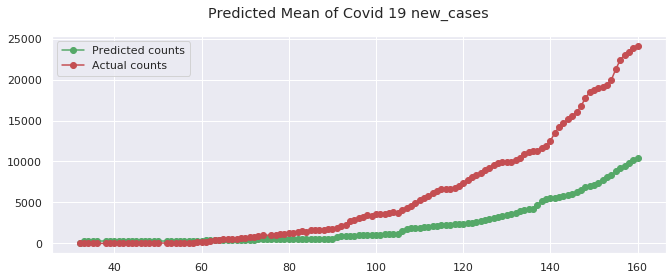

In [151]:
predicted_counts, actual_counts = plot_results_1(predictions_frame,X_train, y_train.rolling(5).mean().fillna(0),X_train_nld, y_train_nld, India, 'new_cases')
scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
for i in scores: {}
    #print(i, i(actual_counts*np.std(India['new_cases']),predicted_counts*np.std(India['new_cases'])))

In [152]:
def date_conversion(date_string):
    datetime_object = datetime.strptime(date_string, '%Y-%m-%d')
    return datetime_object.date()
actual_dates = India.head(train_size).apply(lambda row: date_conversion(row.Dates), axis = 1)
predicted_dates = India.head(train_size+1).apply(lambda row: date_conversion(row.Dates), axis = 1)

In [153]:
def plot_results_final(acutal_dates, actual_counts, predicted_dates, predicted_counts, label1, label2, title):
    # months = mdates.MonthLocator()   # every year
    weeks = mdates.WeekdayLocator()  # every month
    months_fmt = mdates.DateFormatter('%d/%m/%y')

    # Load a numpy structured array from yahoo csv data with fields date, open,
    # close, volume, adj_close from the mpl-data/example directory.  This array
    # stores the date as an np.datetime64 with a day unit ('D') in the 'date'
    # column.
    #with cbook.get_sample_data('goog.npz') as datafile:
     #   data = np.load(datafile)['price_data']

    fig, ax = plt.subplots()
    ax.plot(actual_dates, actual_counts,label =label1, color = 'b', linestyle = 'dashdot', linewidth = 4)
    ax.plot(predicted_dates, predicted_counts,label = label2, color = 'g', linewidth = 2)
    # format the ticks
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(months_fmt)
    #ax.xaxis.set_minor_locator(months)

    # round to nearest years.
    #datemin = np.datetime64(date_actual[1], 'Y')
    #datemax = np.datetime64(date_actual[len(date_actual)-1], 'Y') + np.timedelta64(1, 'Y')
    #ax.set_xlim(datemin, datemax)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    #ax.grid(True)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()

    plt.legend()
    plt.title(title)
    plt.show()


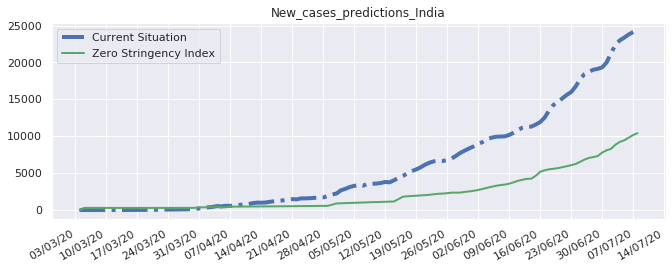

In [154]:
plot_results_final(actual_dates, actual_counts, predicted_dates, predicted_counts,'Current Situation', 'Zero Stringency Index', 'New_cases_predictions_India' )

In [155]:
cumm_actual_counts= []
counts = 0
for i in actual_counts:
    counts += i
    cumm_actual_counts.append(counts)

In [156]:
cumm_predicted_counts = []
counts = 0
for i in predicted_counts:
    counts+=i
    cumm_predicted_counts.append(counts)

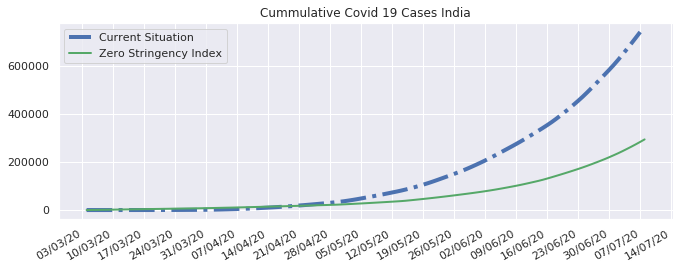

In [157]:
plot_results_final(actual_dates, cumm_actual_counts, predicted_dates, cumm_predicted_counts,'Current Situation', 'Zero Stringency Index', 'Cummulative Covid 19 Cases India' )

In [158]:
X_train_d, y_train_d, X_test_d, y_test_d, test_dates_d = train_test_split(India, 1,expr7, 'Full Lockdown') 
X_train_nld_d, y_train_nld_d, X_test_d, y_test_d, dates_d = train_test_split(India, 1,expr7, 'No Lockdown') 

Training data set length=333
Testing data set length=0
Training data set length=333
Testing data set length=0


In [159]:
model = train_model(y_train_d, X_train_d)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             new_deaths   No. Observations:                  126
Model:                            GLM   Df Residuals:                      122
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3203.3
Date:                Wed, 15 Jul 2020   Deviance:                       5709.6
Time:                        16:48:17   Pearson chi2:                 1.03e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [160]:
predictions_frame_d = (predict(model, X_train_nld_d)).rolling(2).mean().fillna(0)
len(predictions_frame_d)

           mean    mean_se  mean_ci_lower  mean_ci_upper
32    10.918541   0.417083      10.130926      11.767388
33    10.918541   0.417083      10.130926      11.767388
34    10.927059   0.417385      10.138871      11.776520
35    10.902077   0.416498      10.115570      11.749737
36    10.903114   0.416535      10.116537      11.750849
..          ...        ...            ...            ...
156  520.546052  25.895865     472.186980     573.857821
157  528.427051  26.182157     479.523908     582.317468
158  537.925934  26.527530     488.366576     592.514567
159  552.064676  27.042380     501.527366     607.694469
160  571.285968  27.744173     519.416146     628.335603

[127 rows x 4 columns]


127

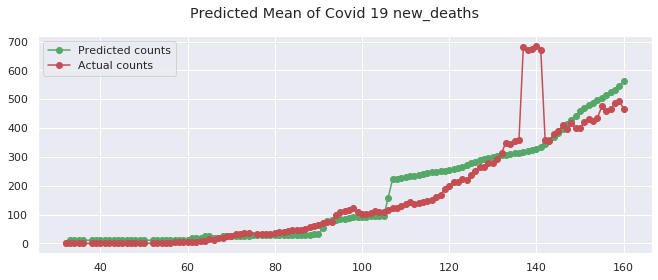

In [161]:
predicted_counts_d, actual_counts_d = plot_results_1(predictions_frame_d,X_train_d, y_train_d.rolling(5).mean().fillna(0),X_train_nld, y_train_nld, India, 'new_deaths')
scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
for i in scores: {}
    #print(i, i(actual_counts*np.std(India['new_cases']),predicted_counts*np.std(India['new_cases'])))

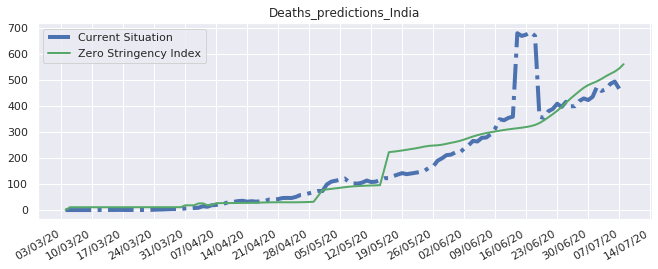

In [162]:
plot_results_final(actual_dates, actual_counts_d, predicted_dates, predicted_counts_d,'Current Situation', 'Zero Stringency Index', 'Deaths_predictions_India' )

In [163]:
cumm_actual_counts_d= []
counts = 0
for i in actual_counts_d:
    counts += i
    cumm_actual_counts_d.append(counts)

In [164]:
cumm_predicted_counts_d = []
counts = 0
for i in predicted_counts_d:
    counts+=i
    cumm_predicted_counts_d.append(counts)

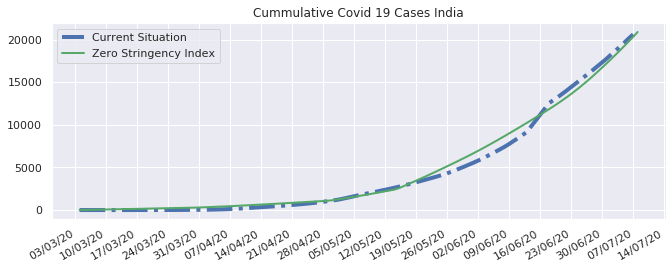

In [165]:
plot_results_final(actual_dates, cumm_actual_counts_d, predicted_dates, cumm_predicted_counts_d,'Current Situation', 'Zero Stringency Index', 'Cummulative Covid 19 Cases India' )